In [1]:
import tables as tb
import pandas as pd
from glob import glob
import re
import os
from invisible_cities.core  .configure import configure
import sys
import math
import invisible_cities.io.dst_io as dio
from invisible_cities.io.table_io import make_table
from invisible_cities.cities.components import index_tables

import sklearn.metrics as skm
import matplotlib.pyplot as plt

import numpy as np
import matplotlib        as mpl
import matplotlib.pyplot as plt

from   mpl_toolkits.mplot3d import Axes3D
from   matplotlib.patches   import Patch

from utils.plotting_utils import plot_label_creator, plot_adaption_hits_to_voxel_scale, plot_cloud_voxels_and_hits_discrete_blobs
from utils.blob_distances_utils import get_dist_blob_isaura, bin_creator

In [2]:
file = 'JA_files/merged_beersheba_label_4mm_50scut.h5'

In [3]:
with tb.open_file(file, 'r') as h5in:
    print(h5in)

JA_files/merged_beersheba_label_4mm_50scut.h5 (File) ''
Last modif.: 'Mon Apr 25 18:18:33 2022'
Object Tree: 
/ (RootGroup) ''
/DATASET (Group) ''
/DATASET/BeershebaVoxels (Table(5796404,), shuffle, zlib(4)) ''
/DATASET/BinsInfo (Table(1,), shuffle, zlib(4)) ''
/DATASET/EventsInfo (Table(28767,), shuffle, zlib(4)) ''
/DATASET/IsauraInfo (Table(40719,), shuffle, zlib(4)) ''
/DATASET/MCHits (Table(7168681,), shuffle, zlib(4)) ''



In [4]:
isaura_info = dio.load_dst(file, 'DATASET', 'IsauraInfo')

In [5]:
beersh_voxels = dio.load_dst(file, 'DATASET', 'BeershebaVoxels')

In [6]:
events_info = dio.load_dst(file, 'DATASET', 'EventsInfo')

In [7]:
MC_hits = dio.load_dst(file, 'DATASET', 'MCHits')

In [8]:
bins_info = dio.load_dst(file, 'DATASET', 'BinsInfo')

### Creador de bines

In [10]:
def bin_creator(bins_info):
    '''
    This function creates the bins for each coordinate from the BinsInfo table in our data.
    
    Args:
        bins_info: pd.DataFrame
    Information of the voxelization in the labelled file.
    
    RETURNS:
        bins_x, bins_y, bins_z: ARRAYS
    Binning in the three coordinates.
    
    '''
    
    min_x, max_x, nbins_x = bins_info.min_x.values[0], bins_info.max_x.values[0], int(bins_info.nbins_x.values[0])
    min_y, max_y, nbins_y = bins_info.min_y.values[0], bins_info.max_y.values[0], int(bins_info.nbins_y.values[0])
    min_z, max_z, nbins_z = bins_info.min_z.values[0], bins_info.max_z.values[0], int(bins_info.nbins_z.values[0])
    
    bins_x = np.linspace(min_x, max_x, nbins_x)
    bins_y = np.linspace(min_y, max_y, nbins_y)
    bins_z = np.linspace(min_z, max_z, nbins_z)
    
    return bins_x, bins_y, bins_z

In [11]:
bins = bin_creator(bins_info)

Quitar lo de astype(int) y mirar para cada set de voxeles los casos en los que hay algun NaN, y si hay mirar que coordenada es y meterlo en el voxel más cercano y PISTA no?? No es tan sencillo pero weno

En x e y no va a pasar ya que cubre todo el espacio, solo puede pasar en z que deja fuera un par de mm... y esto me hace pensar... qué tiene más sentido, dejar fuera ese par de mm o añadir un par de mm al volumen, SABIENDO que aunque un voxel q tiene parte fuera esté lleno, realmente sólo hay chicha en la parte de dentro del detector... tampoco es tan drástico... 

BUENO definitivamente decidí aumentar el binado para que todos los hits cupieran dentro, ROLLO PONER EN Z [0, 552] PARA QUE PUDIERA VOXELIZAR EN TAMAÑO 4, PERO EL ULTIMO VOXEL [548, 552] SÓLO TENDRÁ HITS EN SU MITAD, ALGO QUE PIENSO QUE NO NOS IMPORTA MUCHO NO? ROLLO SON MUY POCOS CASOS Y EN LOS QUE SON, TAMPOCO ES QUE VAYA A SER UNA LOCURA... ERA ESO O DEJARLO FUERA, Y REALMENTE ME DA IGUAL DEJARLO FUERA PERO LUEGO ISAURA Q?? A NO SER Q LE APLIQUE TB UN HITS_DATA_CUT

Vale lo anterior es obvio q se puede hacer porque pensemoslo así: en xy el detector es cilindrico de radio 200mm; sin embargo nosotros tenemos una voxelización de [-220, 220], aplicando un corte en radio a los hits de 200mm... eso hace q no haya hits fuera del cilindro (ya no los iba a haber) PERO al mismo tiempo, algunos voxeles del grid xy FORZADAMENTE van a salirse si resulta que hay algún hit en ellos!!!

Tengo varios criterios para ''clasificar'' cada traza:

* BINCLASS: la True MC info
* ISAU_BINCLASS: nos dice si una traza es señal o no según un threshold en la energía del blob2; viene del análisis de las trazas de isaura.
* COINCIDENCE_BINCLASS: puedo elaborar una tercera binclass en la que si el blob1_seg se llena y el blob2_seg no lo tomamos como fondo, si los dos parámetros se llenan lo tomamos como señal
* LABEL_BINCLASS: podemos tomar la fila en la que contamos blobs de beersheba para decir vale, este evento de labelling DIO BIEN en número de blobs y eso (q va a ser la mayoría que yo tenía bastante buena success rate)

### Voxelizado blobs isaura (puntos extremos)

In [49]:
def voxelize_isaura_blobs(isaura_info, bins, colposition = [26, 32]):
    '''
    bins es [bins_x, bins_y, bins_z]
    
    THE FILLNA SHOULD BE AVOIDED... (by exceeding the limits in the z position when voxelizing!!)
    '''
    for colname, bi in zip(isaura_info.columns[colposition[0]:colposition[1]], bins * 2):
        isaura_bin = pd.cut(isaura_info[colname], bi, labels = np.arange(0, len(bi)-1)).fillna(0).astype(int)
        isaura_info = isaura_info.assign(**{colname + 'bin' : isaura_bin})
        
    return isaura_info

In [ ]:
isaura_voxels = voxelize_isaura_blobs(isaura_info, bins)

### Funciones para ver si algún voxel segclass cae en cierta esfera alrededor de los voxeles isaura (extremos)

In [13]:
def blob_sphere_radius(bins_info, radius):
    '''
    This function transforms a radius into a number of voxels for our voxelization 
    '''
    bins_size = bins_info.size_x.values[0], bins_info.size_y.values[0], bins_info.size_z.values[0]
    scaled_radius = [int(np.ceil(radius/size)) for size in bins_size]
    return scaled_radius

In [14]:
scaled_radius = blob_sphere_radius(bins_info, 20)

In [14]:
def identify_sphere_voxels(isaura_voxels, 
                           blob_voxels,
                           scaled_radius, 
                           coord_names, 
                           center_names, 
                           blob_segname, 
                           blob_elename):
    '''
    Gets the closest blob voxel inside an sphere of certain radius centered in an isaura blob. This
    is used after we tried to identify a track end from isaura with some blob labelled voxel and didn't 
    succeed.
    '''
    #get all the possible sphere centres form the blobs that didn't match any segclass blob
    center_voxels = isaura_voxels[isaura_voxels[blob_segname].isnull()][['dataset_id'] + center_names]
            
    #now do a loop on all the centres
    for i, row in center_voxels.iterrows():
        #get the values of a particular center
        center_coord = row[center_names].values
        #get all the blob voxels for this particular event (from the beersh_voxels that were blob)
        event_blob_voxel = blob_voxels[blob_voxels.dataset_id == row.dataset_id]
    
        #check that we have any blob voxel!
        if event_blob_voxel.empty:
            continue
        
        #compute the distance from the blob centre to all the blob voxel candidates (selected before)
        #using the ellipsoid equation
        distance_to_center = (((event_blob_voxel[coord_names] - center_coord) / np.array(scaled_radius)) ** 2).sum(axis = 1)
                
        #from all of them we just need one, we get the closest
        min_dist = distance_to_center[distance_to_center == min(distance_to_center)]
        if min_dist.values[0] < 1:
            min_id = min_dist.index[0]
            inside_voxel = blob_voxels.loc[min_id]
            
            #i dont know if changing the blob center is suitable, maybe i should create a new column for the "close"
            #kind of blob voxels, instead of changing them, or mantain the centre and mark in some way that although
            #we've assigned it a blob class, it is not really its property
            #isaura_voxels.loc[row.name, center_names[0]] = inside_voxel[coord_names[0]]
            #isaura_voxels.loc[row.name, center_names[1]] = inside_voxel[coord_names[1]]
            #isaura_voxels.loc[row.name, center_names[2]] = inside_voxel[coord_names[2]]
            isaura_voxels.loc[row.name, blob_segname] = inside_voxel.segclass
            isaura_voxels.loc[row.name, blob_elename] = inside_voxel.elem
            
    return isaura_voxels
    

In [50]:
def identify_isaura_blobs(isaura_voxels, beersh_voxels, scaled_radius, segclass = [3, 6], radius = 0, coord_names = ['xbin', 'ybin', 'zbin']):
    '''
    Matches the blob labelled beersheba voxels with the isaura voxels (voxelized isaura blob centres)
    Also, if a blob centre doesn't have any match, we search for it in an sphere of certain radius
    '''
    
    blob_voxels = beersh_voxels[['dataset_id', 'xbin', 'ybin', 'zbin', 'segclass', 'elem']][np.isin(beersh_voxels.segclass, segclass)]
    
    
    for name in ['blob1', 'blob2']:
        center_names = [name + '_xbin', name + '_ybin', name + '_zbin']
        blob_segname, blob_elename = name + '_seg', name + '_ele'
        
        isaura_voxels = isaura_voxels.merge(blob_voxels, 
                                            left_on = ['dataset_id'] + center_names, 
                                            right_on = ['dataset_id'] + coord_names, 
                                            how = 'left').drop(['xbin', 'ybin', 'zbin'], 
                                                               axis = 1).rename(columns = {'segclass':blob_segname, 
                                                                                           'elem':blob_elename})
        #Ahora, EN CASO de que un blob de traza no hubiera sido identificado con ningún voxel blob, 
        # hago una búsqueda POR CADA TRAZA de la esfera para ver si hay voxeles de segmentacion (es decir,
        # del df blob_voxels) que caigan dentro de dicha esfera!!
        if radius > 0:
            isaura_voxels = identify_sphere_voxels(isaura_voxels, 
                                                   blob_voxels, 
                                                   scaled_radius, 
                                                   coord_names, 
                                                   center_names, 
                                                   blob_segname, 
                                                   blob_elename)

            
    return isaura_voxels

In [51]:
def identify_isaura_blobs_class(isaura_voxels, beersh_voxels, coord_names = ['xbin', 'ybin', 'zbin']):
    '''
    Matches the blob labelled beersheba voxels with the isaura voxels (voxelized isaura blob centres)
    Also, if a blob centre doesn't have any match, we search for it in an sphere of certain radius
    '''
    
    blob_voxels = beersh_voxels[['dataset_id', 'xbin', 'ybin', 'zbin', 'segclass', 'elem']]
    
    
    for name in ['blob1', 'blob2']:
        center_names = [name + '_xbin', name + '_ybin', name + '_zbin']
        blob_segname, blob_elename = name + '_seg', name + '_ele'
        
        isaura_voxels = isaura_voxels.merge(blob_voxels, 
                                            left_on = ['dataset_id'] + center_names, 
                                            right_on = ['dataset_id'] + coord_names, 
                                            how = 'left').drop(['xbin', 'ybin', 'zbin'], 
                                                               axis = 1).rename(columns = {'segclass':blob_segname, 
                                                                                           'elem':blob_elename})
            
    return isaura_voxels

In [52]:
isaura_voxels = isaura_voxels.merge(events_info[['dataset_id', 'binclass']], on = 'dataset_id')

NameError: name 'isaura_voxels' is not defined

### Funciones para ver cómo coincidieron los extremos isaura con mi labelling

In [17]:
def check_isaura_coincidence(isaura_voxels, segclass = [3, 6]):
    '''
    Checks which isaura tracks coincide with the labelling, adding some columns to the isaura info dataframe.
    The new information has a 'bkg_coincidence' column where True when one isaura extreme was identified, otherwise
    False; 'sig_coincidence' column where True when two isaura extremes were identified, otherwise False; and
    a 'coincidence_binclass' column where True from 'bkg_coincidence' is 0, and True from 'sig_coincidence' is 1,
    the rest (non identified tracks) is NaN.
    '''
    
    bkg_coincidence = (np.isin(isaura_voxels.blob1_seg, segclass)) & (isaura_voxels.blob2_seg.isnull())
    sig_coincidence = (np.isin(isaura_voxels.blob1_seg, segclass)) & (np.isin(isaura_voxels.blob2_seg, segclass))
    
    isaura_voxels = isaura_voxels.assign(bkg_coincidence = bkg_coincidence, sig_coincidence = sig_coincidence)

    bkg = isaura_voxels.bkg_coincidence.apply(lambda x: 0 if x == True else np.nan)
    sig = isaura_voxels.sig_coincidence.apply(lambda x: 1 if x == True else np.nan)
    
    isaura_voxels = isaura_voxels.assign(coincidence_binclass = bkg.fillna(sig))
    return isaura_voxels

### La clase dada por isaura, definida por un corte en el blob2

In [9]:
blob2_cut = 0.2659 

### Funciones para coger el inicio de las trazas de background, y compararlas con los extremos de isaura

In [19]:
def get_track_start(file, bins):
    '''
    Function to extract from the MCHits DataFrame the starting point of a background track 
    to compare with isaura if this point is correct (the same we did with the blobs).
    This starting point is voxelized as required.
    '''
    mchits = dio.load_dst(file, 'DATASET', 'MCHits')
    track_start = mchits[(mchits.binclass == 0) & (mchits.segclass == 2) & (mchits.hit_id == 0)][['dataset_id', 'x', 'y', 'z']]
    
    for colname, bi in zip(track_start.columns[1:], bins):
        coord_bin = pd.cut(track_start[colname], bi, labels = np.arange(0, len(bi)-1)).astype(int)
        track_start = track_start.assign(**{colname + 'bin_start' : coord_bin})
    
    track_start = track_start.drop(['x', 'y', 'z'], axis = 1)
    return track_start

In [20]:
def track_start_coincidence(isaura_voxels, file, bins, scaled_radius):
    '''
    Adds to the isaura information table a boolean column: 'start_track_coincidence', True if
    the MC track start finds the blob2 isaura end within a sphere, False otherwise.
    '''
    track_start_vox = get_track_start(file, bins)
    isaura_voxels = isaura_voxels.merge(track_start_vox, on = 'dataset_id', how = 'outer')
    
    start_track_dist = (((isaura_voxels[['xbin_start', 'ybin_start', 'zbin_start']] \
                            - isaura_voxels[['blob2_xbin', 'blob2_ybin', 'blob2_zbin']].values)\
                           / scaled_radius) **2).values.sum(axis = 1)
    
    #Check if the distance is <1 for the ellipsoid equation only for the bkg tracks
    start_track_map = np.less(start_track_dist, 1, where=~np.isnan(start_track_dist), 
                              out = np.full(len(start_track_dist), False))
    isaura_voxels = isaura_voxels.assign(start_track_coincidence = start_track_map)
    return isaura_voxels

## Function that congregates all the previous functions

In [21]:
def isaura_analysis(file_path, segclass = [3, 6], blob2_cut = 0.2659, radius = 0):
    '''
    
    '''
    #Get the file information
    beersh_voxels = dio.load_dst(file_path, 'DATASET', 'BeershebaVoxels')
    isaura_info   = dio.load_dst(file_path, 'DATASET', 'IsauraInfo')
    events_info   = dio.load_dst(file_path, 'DATASET', 'EventsInfo')
    bins_info     = dio.load_dst(file_path, 'DATASET', 'BinsInfo')
    
    #Add to the isaura_info, the binclass for each event
    binclass_isaura = isaura_info.merge(events_info[['dataset_id', 'binclass']], on = 'dataset_id')
    
    #Voxelize the isaura ends
    bins_x, bins_y, bins_z = bin_creator(bins_info)
    isaura_voxels = voxelize_isaura_blobs(binclass_isaura, [bins_x, bins_y, bins_z])
    
    #Scale the radius with the voxel sizes
    scaled_radius = blob_sphere_radius(bins_info, radius)
    
    #Search for blob labelled voxels within a sphere surrounding the isaura ends, and get 
    #results from that (whether a track is signal or bkg depending on the coincidence between
    #labelling and isaura)
    isaura_voxels = identify_isaura_blobs(isaura_voxels, beersh_voxels, scaled_radius, segclass = segclass, radius = radius)
    isaura_voxels = check_isaura_coincidence(isaura_voxels)
    
    #Add the classification with the blob2 threshold to consider it a blob or not
    isaura_voxels = isaura_voxels.assign(isau_binclass = isaura_voxels.eblob2 > blob2_cut)
    isaura_voxels.isau_binclass = isaura_voxels.isau_binclass.astype('int')
    
    #Add the blob counting column to the isaura information dataframe
    if np.isin('nblob', beersh_voxels.columns):
        isaura_voxels = isaura_voxels.merge(beersh_voxels[['dataset_id', 'nblob']].drop_duplicates(), on = 'dataset_id')
    
    #Add the start track information to the isaura dataframe
    isaura_voxels = track_start_coincidence(isaura_voxels, file_path, [bins_x, bins_y, bins_z], scaled_radius)
    
    return isaura_voxels

In [40]:
isaura_voxels_radius = isaura_analysis(file, radius = 21)

In [22]:
def extract_isaura_statistics(isaura_voxels, main_tracks = False):
    '''
    Gets for the main tracks (if the variable is True) the confusion matrix for the isaura binclass 
    and for the coincidence with my labelling. Besides, it also computes the accuracy for the bkg starting tracks
    finding.
    '''
    if main_tracks == True:
        isaura_voxels = isaura_voxels[isaura_voxels.trackID == 0]
        
    #Confusion matrix for the isaura class (blob2 threshold) and 
    isau_binclass_matrix = skm.confusion_matrix(isaura_voxels.binclass.values, isaura_voxels.isau_binclass.values)
    
    coincidence_matrix = skm.confusion_matrix(isaura_voxels.binclass.values, isaura_voxels.coincidence_binclass.fillna(-1).values)
    
    #We need to change columns and rows because our POSITIVE is the signal (labelled as 1) and our
    #NEGATIVE is the bkg (labelled as 0), and because of the order of the labels the matrix is created
    #in the wrong way
    coincidence_matrix[:, [1, 2]] = coincidence_matrix[:, [2, 1]]
    coincidence_matrix[[1, 2], :] = coincidence_matrix[[2, 1], :]
    
    #accuracy for the background starting tracks finding 
    coincidence_start = sum(isaura_voxels[isaura_voxels.binclass == 0].start_track_coincidence) / len(isaura_voxels[isaura_voxels.binclass == 0])
    
    #print('The {:.4f}% of the times, the isaura blob 2 cut of {} MeV succeeded with respect to the true MC info'.format(isau_binclass_acc, blob2_cut))
    #print('The {:.4f}% of the times, a track had either one or the two blobs placed in a blob labelled voxel'.format(placing_acc))
    #print('The {:.4f}% of the times the blob coincidence agreed with the true MC info'.format(coincidence_acc))
    #print('    This is, the {:.4f}% of the times a track had a good blob placement, it was also the correct binclass info'.format(placing_and_coincidence_acc))
    print('The {:.4f}% of the times the start track agreed (for bkg events)'.format(coincidence_start))
    return isau_binclass_matrix, coincidence_matrix, coincidence_start


Yo estoy mirando:
* Comparación BINCLASS-ISAURA BINCLASS (threeshold en el blob2 de isaura)
* Coincidencia EXTREMOS ISAURA-LABELLING BLOBS ---> De esto saco comparación COINCIDENCE BINCLASS-BINCLASS
Me faltaría mirar QUIZÁS una comparación entre COINCIDENCE BINCLASS-ISAURA BINCLASS

In [23]:
def coincidence_matrix_characteristics(coinc_matrix):
    '''
    Gets some parameters from the coincidence matrix:
    placing_acc:      % of tracks that are classified in some way (this is, some of the isaura ends had a 
                      blob labelled voxel inside a sphere of certain radius)
                      
    coincidence_acc:  % of times that a bkg track had one isaura end identified with a blob OR a signal track
                      had had two isaura ends identified and matches the binclass, i.e., the coincidence 
                      criteria matches the binclass.
    
    placing_and_coincidence_acc: % of the times the coincidence criteria matches the binclass BUT JUST for the
                                 tracks that were classified in some way (i.e., for the trakcs that contribute in
                                 the placcing_acc)
    [tpr_full, fpr_full]: true positive rate and false positive rate for the conf. matrix taking into account 
                          the non-placed tracks, placed/classified as bkg, placed/classified as signal
    [tpr_red, fpr_red]: true positive rate and false positive rate for the conf. matrix taking into account 
                        the placed tracks (with two classifications, as signal or bkg)
    '''
    
    coinc_matrix_red = coinc_matrix[1:, 1:] #just takes into account the placed blobs tracks
    
    placing_acc = coinc_matrix_red.sum() / coinc_matrix.sum()
    coincidence_acc = sum(np.diag(coinc_matrix))/coinc_matrix.sum()
    placing_and_coincidence_acc = sum(np.diag(coinc_matrix_red))/coinc_matrix_red.sum()
    
    tpr_full = coinc_matrix[1,1]/np.sum(coinc_matrix[1, :])
    fpr_full = np.sum(coinc_matrix[2, :2])/np.sum(coinc_matrix[2, :])
    
    tpr_red  = coinc_matrix_red[0, 0] / np.sum(coinc_matrix_red[0, :])
    fpr_red  = np.sum(coinc_matrix_red[1, :1])/np.sum(coinc_matrix_red[1, :])
    
    return placing_acc, coincidence_acc, placing_and_coincidence_acc, [tpr_full, fpr_full], [tpr_red, fpr_red]

In [25]:
voxel_rad = [0, 0, 0]
for i in np.arange(1, 30 + 3, 1):
    voxel_rad_new = [int(np.ceil(i/size)) for size in [5, 5, 4]]
    if voxel_rad == voxel_rad_new:
        continue
    print(voxel_rad_new, 'con radio', i)
    voxel_rad = voxel_rad_new

[1, 1, 1] con radio 1
[1, 1, 2] con radio 5
[2, 2, 2] con radio 6
[2, 2, 3] con radio 9
[3, 3, 3] con radio 11
[3, 3, 4] con radio 13
[4, 4, 4] con radio 16
[4, 4, 5] con radio 17
[5, 5, 6] con radio 21
[5, 5, 7] con radio 25
[6, 6, 7] con radio 26
[6, 6, 8] con radio 29
[7, 7, 8] con radio 31


In [109]:
coinc_start_acc, placing_acc, coinc_acc, placing_and_coinc_acc, roc_full_acc, roc_red_acc = [], [], [], [], [], []
radius_size = []
voxel_rad = [0, 0, 0]
for rad in np.arange(1, 30 + 3, 1):
    
    voxel_rad_new = [int(np.ceil(rad/size)) for size in [5, 5, 4]]
    if voxel_rad == voxel_rad_new:
        continue
    #print(voxel_rad_new, 'con radio', rad)
    voxel_rad = voxel_rad_new
    
    isaura_voxels = isaura_analysis(file, radius = rad)
    isau_binclass_matrix, coinc_matrix, coinc_start_val = extract_isaura_statistics(isaura_voxels, main_tracks=True)
    placing_val, coinc_val, placing_and_coinc_val, roc_full_val, roc_red_val = coincidence_matrix_characteristics(coinc_matrix)
    
    radius_size.append(rad)
    coinc_start_acc.append(coinc_start_val)
    placing_acc.append(placing_val)
    coinc_acc.append(coinc_val)
    placing_and_coinc_acc.append(placing_and_coinc_val)
    roc_full_acc.append(roc_full_val)
    roc_red_acc.append(roc_red_val)
    #print(coinc_matrix)
    
roc_full_acc, roc_red_acc = np.array(roc_full_acc), np.array(roc_red_acc)

[1, 1, 1] con radio 1
The 0.0374% of the times the start track agreed (for bkg events)
[[   0    0    0]
 [5776 1198 2485]
 [9747    3 9558]]
[1, 1, 2] con radio 5
The 0.0633% of the times the start track agreed (for bkg events)
[[    0     0     0]
 [ 4833  1952  2674]
 [ 8599     4 10705]]
[2, 2, 2] con radio 6
The 0.4763% of the times the start track agreed (for bkg events)
[[    0     0     0]
 [ 2680  4370  2409]
 [ 6691    13 12604]]
[2, 2, 3] con radio 9
The 0.5091% of the times the start track agreed (for bkg events)
[[    0     0     0]
 [ 2230  4813  2416]
 [ 6126    26 13156]]
[3, 3, 3] con radio 11
The 0.6761% of the times the start track agreed (for bkg events)
[[    0     0     0]
 [ 1495  5741  2223]
 [ 5184    53 14071]]
[3, 3, 4] con radio 13
The 0.6971% of the times the start track agreed (for bkg events)
[[    0     0     0]
 [ 1153  6196  2110]
 [ 4718    77 14513]]
[4, 4, 4] con radio 16
The 0.7326% of the times the start track agreed (for bkg events)
[[    0     0

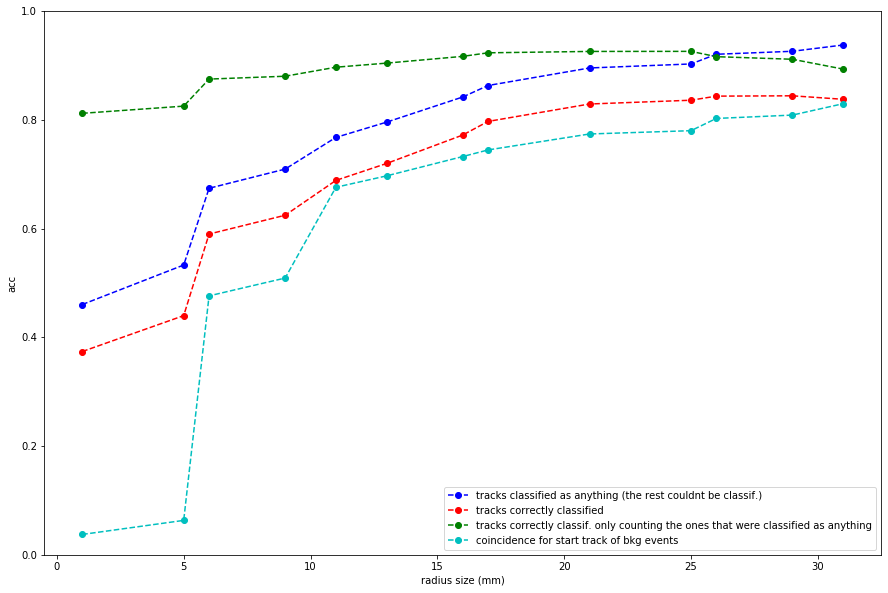

In [128]:
plt.figure(figsize=(15,10))
plt.plot(radius_size, placing_acc, '--bo', label = 'tracks classified as anything (the rest couldnt be classif.)')
plt.plot(radius_size, coinc_acc, '--ro', label = 'tracks correctly classified')
plt.plot(radius_size, placing_and_coinc_acc, '--go', label = 'tracks correctly classif. only counting the ones that were classified as anything')
plt.plot(radius_size, coinc_start_acc, '--co', label = 'coincidence for start track of bkg events')
plt.ylim([0, 1])
plt.legend()

plt.title('Coincidence statistics')
plt.xlabel('radius size (mm)')
plt.ylabel('acc')
plt.title('')
plt.show()

En esta grafica anterior quizás la curva (de las tres primeras) que nos dá una información más realista es la segunda (pq tiene en cuenta los eventos que quedaron sin asignar nada de blob), pero pongo las tres para ver un overall por así decirlo (esto tb nos ayuda quizás a discriminar trazas más chufa de otras mejores, porque si ni siquiera se pudo asignar un blob ni dos, quizás es porque es una traza cativa)

### Signal eff vs bkg rejection

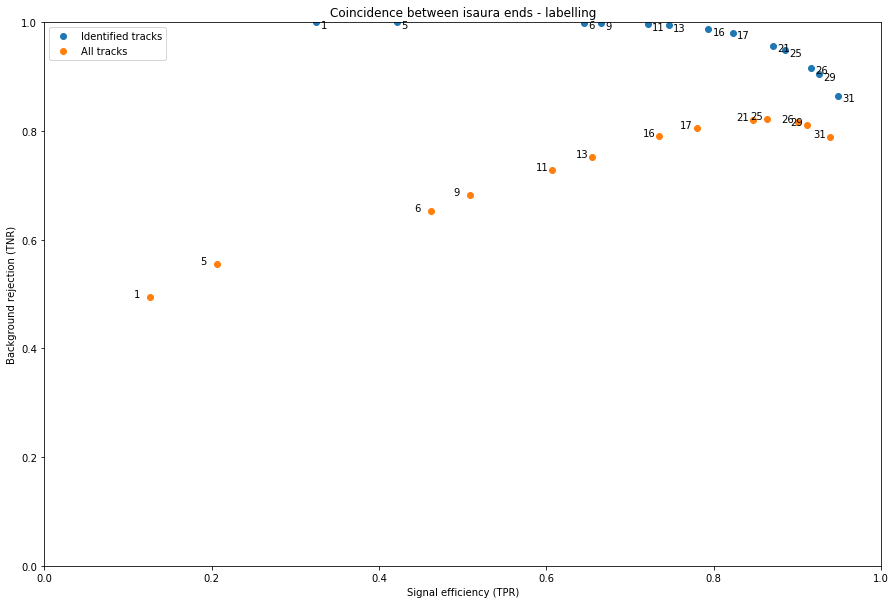

In [129]:
plt.figure(figsize=(15,10))
plt.plot(roc_red_acc[:, 0], 1 - roc_red_acc[:, 1], 'o', label = 'Identified tracks')
for i, txt in enumerate(radius_size):
    plt.annotate(txt, (roc_red_acc[:, 0][i] + 0.005, 1 - roc_red_acc[:, 1][i] - 0.01))

plt.plot(roc_full_acc[:, 0], 1 - roc_full_acc[:, 1], 'o', label = 'All tracks')
for i, txt in enumerate(radius_size):
    plt.annotate(txt, (roc_full_acc[:, 0][i] - 0.02, 1 - roc_full_acc[:, 1][i]))
    
plt.xlabel('Signal efficiency (TPR)')
plt.ylabel('Background rejection (TNR)')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Coincidence between isaura ends - labelling')
plt.legend()
plt.show()

El bkg rejection es bajo para all tracks a radios pequeños porque hay muchos eventos clasificados como bkg simplemente por coincidencia de blob (indep del radio, pues son eventos muy claros y se clasifican bien facil) y el resto son de bkg no identificados, habiendo muy pocas identificaciones como señal siendo una traza de bkg (es decir, no hay falsos positivos prácticamente). 

Por eso la diferencia entre coger all tracks y coger sólo las clasificadas: al ppio baja mucho la background rejection el hecho de haber trazas que no se identifican. También baja la signal efficiency entre los dos obviamente, pero llama más la atención lo otro por la forma típica que sigue la curva

### ROC curve

La siguiente gráfica es la ROC para los eventos que tuvieron algún blob identificado, es decir, que no se quedaron colgados por ahí. El inconveniente que le veo es que no nos da una idea de cuántas trazas no fueron identificadas (que tampoco es que identificar blobs en más trazas sea sinónimo de que va bien, quizás está identificando muchos blob1 en trazas que son de señal... por decir algo)

Tengo también la ROC en la que se cuentant aquellos eventos excluidos, y resulta en una distribución un poco extraña (respecto a la típica ROC)... sin embargo, puedo decir que entiendo que a medida que pasa de 21mm, el radio crece y por tanto más blobs son identificados. 

Lo que pasa a continuación es que aumenta el FPR porque entiendo que el radio es tan grande que los dos puntos de isaura llegan a coger el mismo blob etiquetado por mi, por tanto cuenta como que es señal (porque a ambos les asigna un voxel blob) cuando en verdad es fondo. Al mismo tiempo algo aumenta la TPR por la misma razón: aunque estén lejos los puntos del voxel blob, lo acaban encontrando y al final pues fuerza a que se reconozca un evento de señal.

La solución que le veo a esto sería hacer que una vez un punto blob de isaura se identifique con un voxel blob, todos los de ese grupo se "anulen" y no puedan ser pillados por el otro punto blob. El problema que le veo a esto es en las trazas en las que sí hay dos blobs, pero estan muy pegados, quizás digo que el blob es 1 grupo solo, e isaura reconoce la traza y pone los dos extremos en blob (pero dando toda la vuelta); entonces, cuando un punto blob de isaura se identifica con un voxel blob, anula todo el conjunto voxel blob (que es uno según mi algoritmo en vez de dos por ser la traza retorcidilla) entonces el segundo punto blob nunca va a encontrar blob y falla tb....

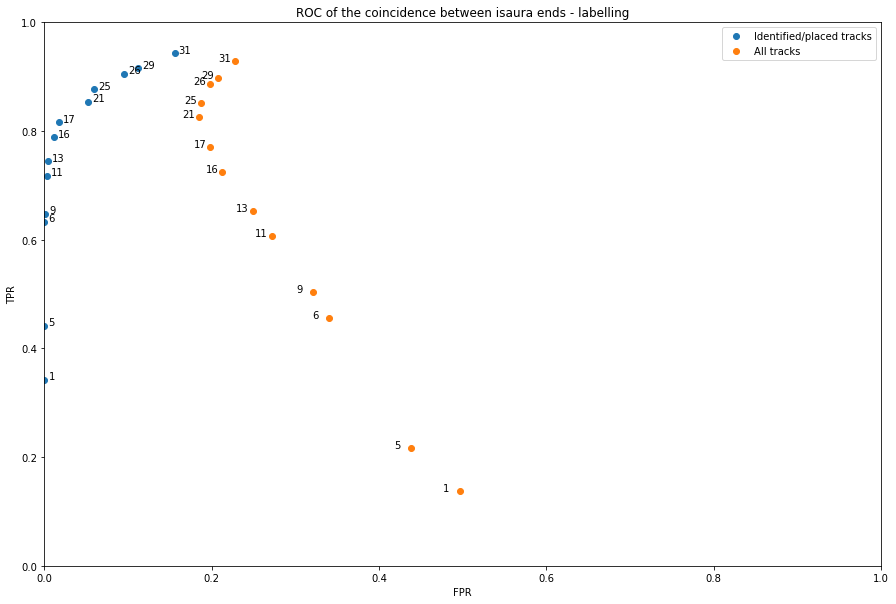

In [36]:
plt.figure(figsize=(15,10))
plt.plot(roc_red_acc[:, 1], roc_red_acc[:, 0], 'o', label = 'Identified/placed tracks')
for i, txt in enumerate(radius_size):
    plt.annotate(txt, (roc_red_acc[:, 1][i] + 0.005, roc_red_acc[:, 0][i] + 0.001))
    
plt.plot(roc_full_acc[:, 1], roc_full_acc[:, 0], 'o', label = 'All tracks')
for i, txt in enumerate(radius_size):
    plt.annotate(txt, (roc_full_acc[:, 1][i] - 0.02, roc_full_acc[:, 0][i]))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.title('ROC of the coincidence between isaura ends - labelling')
plt.show()

Para los radios entre 1 y 21, vemos que la FPR es mayor de lo que una ROC típica da. Esto se debe a que hay muy pocos eventos (o ninguno) que se predigan como positivos (señal) y sean negativos (bkg) en verdad. 

La cosa está repartida entre trazas en las que un punto blob encontró el extremo y trazas en las que no encontró NADA. Y esos eventos en los que no se identificó nada, al ser muchos, aumentan el valor de la FPR (al principio son tantos como los que sí de identificaron aprox, de ahí que la FPR de 1mm ronde el 0.5)

Al mismo tiempo, para estos eventos la TPR es obviamente muy baja porque hay muchos eventos que no son identificados, y otros muchos que solo identifican un blob y clasifican la señal como bkg en lugar de señal.

# GHOST ENERGY DISTRIBUTION

In [9]:
ghost_clouds = beersh_voxels[beersh_voxels.segclass == 7][['dataset_id', 'elem', 'elem_ener', 'cloud', 'cloud_ener']].drop_duplicates()

In [10]:
#eliminate the clouds that arent exclusively from a segclass by equaling the cloud and elem ener
#need to round because some of them have a bit of discordance on the last decimals but not worrying
ghost_clouds = ghost_clouds[round(ghost_clouds.elem_ener, 7) == round(ghost_clouds.cloud_ener, 7)]

In [11]:
other_clouds = beersh_voxels[np.isin(beersh_voxels.segclass, [1, 4]) & (beersh_voxels.cloud != 'c_0')][['dataset_id', 'elem', 'elem_ener', 'cloud', 'cloud_ener']].drop_duplicates()

In [12]:
#the same
other_clouds = other_clouds[round(other_clouds.elem_ener, 7) == round(other_clouds.cloud_ener, 7)]

In [13]:
nbins = 100
xrange = (0, 0.05)

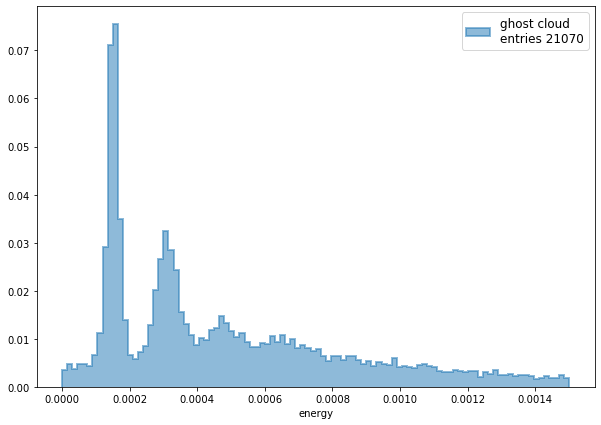

In [14]:
plt.figure(figsize = (10, 7))
data = ghost_clouds.cloud_ener
nevents = len(data)
plt.hist(data, bins = nbins, range = (0, 0.0015), weights=np.ones(nevents) / nevents,
         histtype = 'step', alpha = 0.5, fill = True, linewidth = 2, label = 'ghost cloud \nentries {}'.format(nevents))
plt.xlabel('energy')
plt.legend(prop={'size': 12})
plt.show()

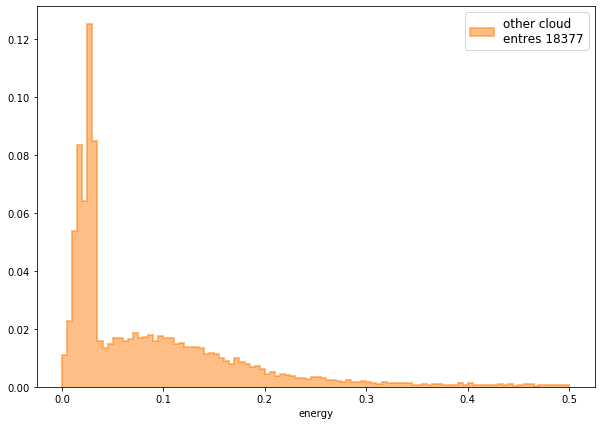

In [15]:
plt.figure(figsize = (10, 7))

data = other_clouds.cloud_ener
nevents = len(data)
plt.hist(data, bins = nbins, range = (0, 0.5), weights=np.ones(nevents) / nevents,
         histtype = 'step', alpha = 0.5, fill = True, linewidth = 2, color = 'tab:orange', 
         label = 'other cloud \nentres {}'.format(nevents))
plt.xlabel('energy')
plt.legend(prop={'size': 12})
plt.show()

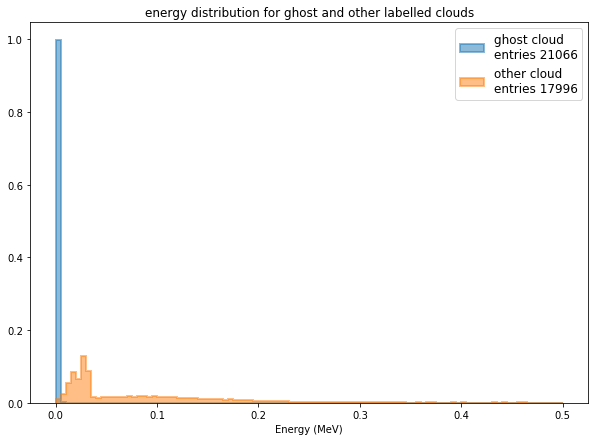

In [16]:
nbins = 100
xrange = (0, 0.5)
plt.figure(figsize = (10, 7))

data = ghost_clouds[ghost_clouds.cloud_ener < xrange[1]].cloud_ener
nevents = len(data)
plt.hist(data, bins = nbins, range = xrange, weights=np.ones(nevents) / nevents,
         histtype = 'step', alpha = 0.5, fill = True, linewidth = 2, label = 'ghost cloud \nentries {}'.format(nevents))

data = other_clouds[other_clouds.cloud_ener < xrange[1]].cloud_ener
nevents = len(data)
plt.hist(data, bins = nbins, range = xrange, weights=np.ones(nevents) / nevents,
         histtype = 'step', alpha = 0.5, fill = True, linewidth = 2, label = 'other cloud \nentries {}'.format(nevents))
plt.xlabel('Energy (MeV)')
plt.title('energy distribution for ghost and other labelled clouds')
plt.legend(prop={'size': 12})
plt.show()

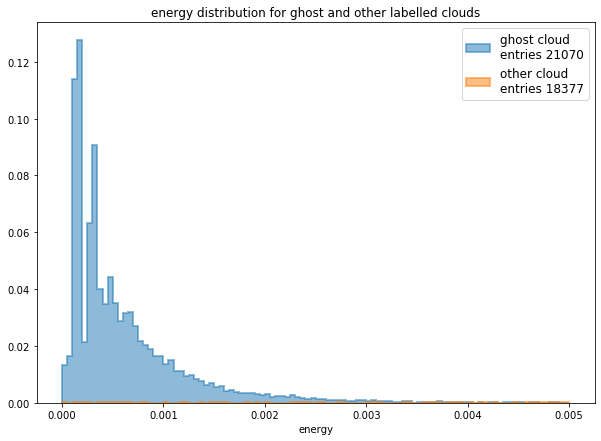

In [17]:
xrange = (0, 0.005)
plt.figure(figsize = (10, 7))
data = ghost_clouds.cloud_ener
nevents = len(data)
plt.hist(data, bins = nbins, range = xrange, weights=np.ones(nevents) / nevents,
         histtype = 'step', alpha = 0.5, fill = True, linewidth = 2, label = 'ghost cloud \nentries {}'.format(nevents))
data = other_clouds.cloud_ener
nevents = len(data)
plt.hist(data, bins = nbins, range = xrange, weights=np.ones(nevents) / nevents,
         histtype = 'step', alpha = 0.5, fill = True, linewidth = 2, label = 'other cloud \nentries {}'.format(nevents))
plt.xlabel('energy')
plt.title('energy distribution for ghost and other labelled clouds')
plt.legend(prop={'size': 12})
plt.show()

In [18]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

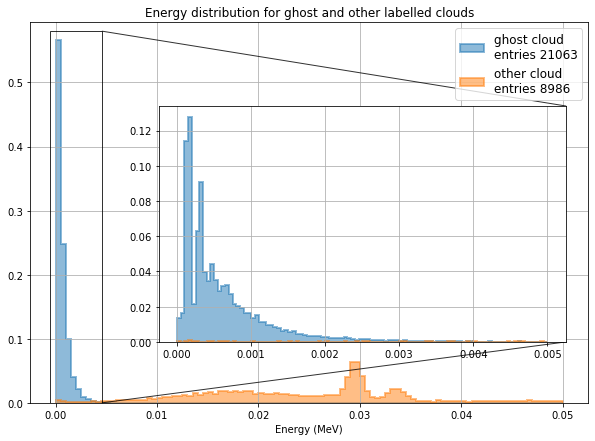

In [19]:
nbins = 100
xrange = (0, 0.05)

fig, ax = plt.subplots(figsize=[10, 7])


data = ghost_clouds[ghost_clouds.cloud_ener < xrange[1]].cloud_ener
nevents = len(data)
ax.hist(data, bins = nbins, range = xrange, weights=np.ones(nevents) / nevents,
         histtype = 'step', alpha = 0.5, fill = True, linewidth = 2, label = 'ghost cloud \nentries {}'.format(nevents))
data = other_clouds[other_clouds.cloud_ener < xrange[1]].cloud_ener
nevents = len(data)
ax.hist(data, bins = nbins, range = xrange, weights=np.ones(nevents) / nevents,
         histtype = 'step', alpha = 0.5, fill = True, linewidth = 2, label = 'other cloud \nentries {}'.format(nevents))

plt.legend(prop={'size': 12}, loc = 'upper right')

# create of the axes inside my original axes
axins = ax.inset_axes([0.23, 0.16, 0.73, 0.62])

xrange_axins = (0, 0.005)
nbins = 100
data = ghost_clouds[ghost_clouds.cloud_ener < xrange[1]].cloud_ener
nevents = len(data)
axins.hist(data, bins = nbins, range = xrange_axins, weights=np.ones(nevents) / nevents,
         histtype = 'step', alpha = 0.5, fill = True, linewidth = 2, label = 'ghost cloud \nentries {}'.format(nevents))
data = other_clouds[other_clouds.cloud_ener < xrange[1]].cloud_ener
nevents = len(data)
axins.hist(data, bins = nbins, range = xrange_axins, weights=np.ones(nevents) / nevents,
         histtype = 'step', alpha = 0.5, fill = True, linewidth = 2, label = 'other cloud \nentries {}'.format(nevents))


#axins.set_xticklabels([])
#axins.set_yticklabels([])


#in this i define the rectangle to indicate where the amplified region is
ax.indicate_inset([-0.0005, 0, 0.0051, 0.58], inset_ax = axins, 
                  edgecolor = 'k', alpha = .8)

#this is if i wanted to do an exact zoom
#ax.indicate_inset_zoom(axins, edgecolor="black")
ax.set_xlabel('Energy (MeV)')
ax.set_title('Energy distribution for ghost and other labelled clouds')
ax.grid()
axins.set_title('')
axins.grid()
plt.show()

# ELEMENT COUNT

In [21]:
def histogram_statistics(full_df, var, xlabel = None, binclass = (0, 1), mean = True, discrete_var = False, print_statistics = False):
    '''
    discrete_var is used for discrete variables just to have the perfect number of bins
    '''
    plot_df = full_df[['dataset_id', 'binclass', var]].drop_duplicates()
    if plot_df[var].dtype == bool:
        plot_df[var] = plot_df[var].astype(int)
    plot_df[var] = plot_df[var].fillna(-1)
    plot_values = plot_df[var].unique()
    
    nbins = len(plot_values[~np.isnan(plot_values)])
    xrange = (plot_df[var].min(), plot_df[var].max() + 1)
    if discrete_var:
        nbins  = int(xrange[1] - xrange[0])
    
    #print(nbins, xrange)
    
    if nbins > 100:
        nbins = 50
        
    names = ['e$^{-}$', 
             'e$^{-}$ e$^{+}$']

    for i in binclass:
        df = plot_df[plot_df.binclass == i]

        info = '\nentries {:.0f}'.format(float(len(df)))
        if mean == True:
            info = info + '\nmean {:.3f} \nstd {:.3f}'.format(np.mean(df[var]), np.std(df[var]))
        hist_info = plt.hist(df[var], nbins, xrange, label = names[i] + info, 
                             histtype = 'step', density = True, alpha = 0.5, fill = True, linewidth = 2)
        if print_statistics:
            print(names[i], hist_info[0] * 100)
        
    plt.legend()
    if xlabel == None:
        xlabel = var
    plt.xlabel(xlabel)
    plt.grid()
    if print_statistics:
        print('total', np.histogram(plot_df[var], bins = nbins, range = xrange, density = True)[0] * 100)
    #plt.show()

I need to add this lines to have the count on how many elements we have in an event (we have the elem count for each element type, i.e. other/track/blob, but not the total number of elements in an event)

In [22]:
elem_df = beersh_voxels[['dataset_id', 'elem']].drop_duplicates()
beersh_voxels = beersh_voxels.merge(elem_df.groupby('dataset_id').count(), on = ['dataset_id'])
beersh_voxels.rename({'elem_x':'elem', 'elem_y':'event_elem_count'}, inplace = True, axis = 1)

### CLOUD COUNT AND DISTRIBUTION OF THE SEGCLASS FOR EVENTS WITH >1 CLOUD

In [23]:
100 - 4.14155108e+01

58.5844892

e$^{-}$ [4.07654858e+01 2.51398384e+01 1.46985705e+01 8.14688212e+00
 4.57323389e+00 2.66728817e+00 1.58483530e+00 9.63331262e-01
 5.33457634e-01 3.83260825e-01 1.65734411e-01 1.13942407e-01
 1.19121608e-01 4.14336027e-02 5.17920033e-02 5.17920033e-03
 1.03584007e-02 2.58960017e-02 0.00000000e+00 5.17920033e-03
 0.00000000e+00 0.00000000e+00 5.17920033e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
e$^{-}$ e$^{+}$ [4.27423618e+01 2.43894703e+01 1.43144096e+01 7.83380907e+00
 4.32392430e+00 2.60069775e+00 1.53293160e+00 8.35183423e-01
 5.92028756e-01 3.27730204e-01 2.43154668e-01 7.40035945e-02
 7.40035945e-02 5.28597103e-02 1.05719421e-02 2.11438841e-02
 2.11438841e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.05719421e-02]
total [4.14155108e+01 2.48931067e+01 1.45722529e+01 8.04393924e+00
 4.49125734e+00 2.64539229e+00 1.56776862e+00 9.21194424e-01
 5.52716654e-01 3.65001564e-01 1.91191296e-01 1.0080

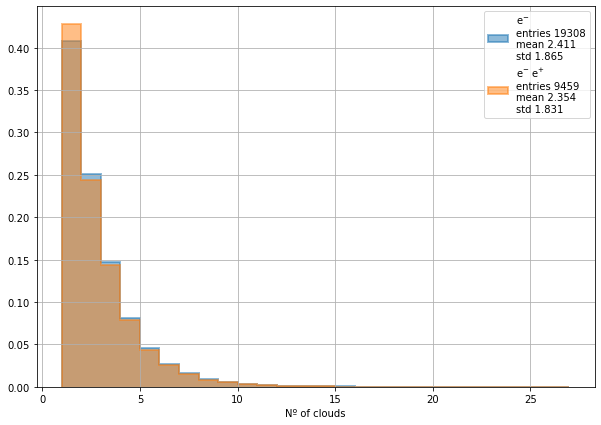

In [24]:
%matplotlib inline
plt.figure(figsize = (10, 7))
histogram_statistics(beersh_voxels, 'cloud_count', 'Nº of clouds', discrete_var = True, print_statistics=True)


Miro qué tipo de elementos son las nubes no principales. Nos quedamos con todas las clouds no principales y con cada tipo de voxel que tienen. Es decir si la cloud 2 de un evento tiene clases 1 y 2 pues nos quedaremos con una fila c_2 con segclass 1 y otra fila c_2 con segclass 2.

#### Es decir, no miramos la abundancia total de cada clase en las nubes secundarias, sino que miramos qué clases hay en cada nube secundaria

In [25]:
non_principal_clouds = beersh_voxels[(beersh_voxels.cloud != 'c_0')][['dataset_id', 'binclass', 'cloud', 'segclass']]
non_principal_clouds.segclass = non_principal_clouds.segclass.apply(lambda x: {1:1, 2:2, 3:3, 4:1, 5:2, 6:3, 7:4}[x])
non_principal_clouds = non_principal_clouds.drop_duplicates()

e$^{-}$ [46.72683776  1.71451356  0.3661012  51.19254748]
e$^{-}$ e$^{+}$ [44.67428219  0.94164866  0.81043532 53.57363384]
total [46.07093528  1.46754144  0.50808998 51.95343331]


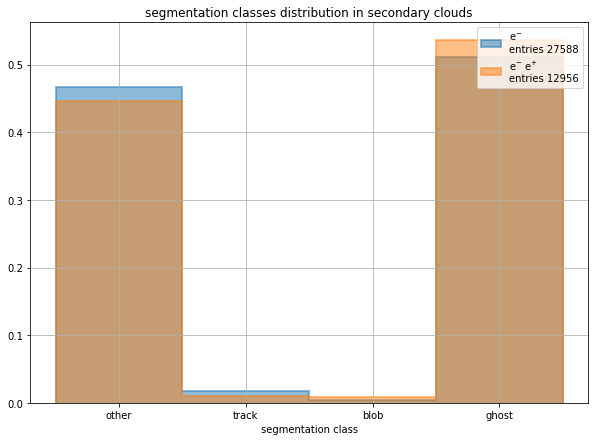

In [26]:
plt.figure(figsize = (10, 7))

xlabel = 'segmentation class'
var = 'segclass'
binclass = (0, 1)

plot_df = non_principal_clouds.copy()
plot_values = plot_df[var].unique()

xrange = (plot_df[var].min(), plot_df[var].max() + 1)
nbins  = int(xrange[1] - xrange[0])  

if nbins > 100:
    nbins = 50
        
names = ['e$^{-}$', 
         'e$^{-}$ e$^{+}$']

for i in binclass:
    df = plot_df[plot_df.binclass == i]

    info = '\nentries {:.0f}'.format(float(len(df)))

    hist_info = plt.hist(df[var], nbins, xrange, label = names[i] + info, 
                         histtype = 'step', density = True, alpha = 0.5, fill = True, linewidth = 2)
    
    print(names[i], hist_info[0] * 100)


print('total', np.histogram(plot_df[var], nbins, xrange, density = True)[0] * 100)

plt.legend()
if xlabel == None:
    xlabel = var
plt.title('segmentation classes distribution in secondary clouds')
plt.xticks(np.arange(1.5, 5.5, 1), ['other', 'track', 'blob', 'ghost'])
plt.xlabel(xlabel)
plt.grid()
plt.show()

Porcentaje de ELEMENTOS de traza/blob fuera de la nube principal (respecto al total de elementos que se encuentran tb fuera de la nube principal)

In [27]:
1.46754144 + 0.50808998 

1.97563142

Porcentaje de EVENTOS con elementos de traza/blob fuera de la principal (respecto al total de eventos):

In [28]:
len(non_principal_clouds[(np.isin(non_principal_clouds.segclass, [2, 3]))].dataset_id.unique()) /len(beersh_voxels.dataset_id.unique()) * 100

2.0057705009211944

In [29]:
for i in non_principal_clouds.segclass.unique():
    for j in (0, 1):
        event_list = non_principal_clouds[(non_principal_clouds.segclass == i) & (non_principal_clouds.binclass == j)].dataset_id.unique()
        
        print('{} BINCLASS {} EVENTS FOR VOXELS OUT OF THE MAIN CLOUD WITH SEGCLASS {}'.format(len(event_list), j, i))
        print(event_list)

8425 BINCLASS 0 EVENTS FOR VOXELS OUT OF THE MAIN CLOUD WITH SEGCLASS 1
[    0     4     5 ... 28751 28760 28766]
3838 BINCLASS 1 EVENTS FOR VOXELS OUT OF THE MAIN CLOUD WITH SEGCLASS 1
[    1     2     6 ... 28762 28763 28764]
6525 BINCLASS 0 EVENTS FOR VOXELS OUT OF THE MAIN CLOUD WITH SEGCLASS 4
[    3     4     5 ... 28746 28761 28766]
3171 BINCLASS 1 EVENTS FOR VOXELS OUT OF THE MAIN CLOUD WITH SEGCLASS 4
[    6    10    24 ... 28757 28763 28765]
447 BINCLASS 0 EVENTS FOR VOXELS OUT OF THE MAIN CLOUD WITH SEGCLASS 2
[   20   204   246   309   376   436   469   501   836   967   983  1174
  1412  1423  1439  1468  1507  1514  1557  1872  1954  1992  2001  2005
  2133  2137  2229  2233  2316  2378  2500  2572  2619  2684  2701  2912
  2939  2994  3068  3098  3116  3278  3363  3384  3396  3406  3544  3680
  3707  3785  3794  3917  4013  4036  4060  4061  4088  4123  4156  4195
  4223  4428  4477  4559  4641  4971  4977  5020  5026  5058  5095  5103
  5112  5138  5152  5188  5192  520

In [30]:
track_counting = beersh_voxels[np.isin(beersh_voxels.segclass, [2, 5])][['dataset_id', 'binclass', 'segclass', 'elem_count']].drop_duplicates()


e$^{-}$ [9.51144959e+01 4.67827168e+00 1.81328360e-01 2.07232411e-02
 5.18081028e-03]
e$^{-}$ e$^{+}$ [9.72078265e+01 2.71813855e+00 7.40349022e-02 0.00000000e+00
 0.00000000e+00]
total [9.58027611e+01 4.03380047e+00 1.46051396e-01 1.39096568e-02
 3.47741419e-03]


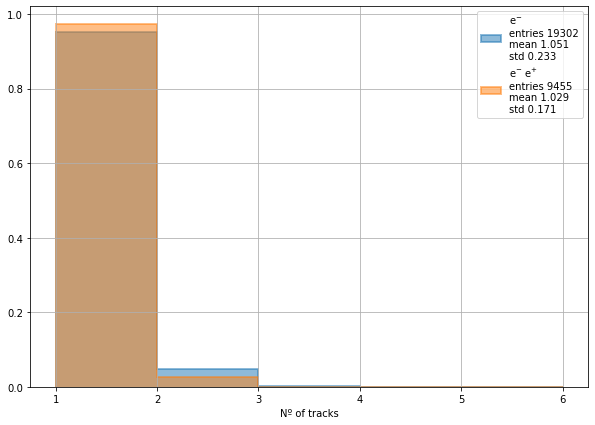

In [31]:
%matplotlib inline
plt.figure(figsize = (10, 7))
histogram_statistics(track_counting, 'elem_count', 'Nº of tracks', discrete_var = True, print_statistics=True)


Percentage of events with more than 1 element labelled as track:

In [32]:
4.03380047e+00 +  1.46051396e-01 + 1.39096568e-02 + 3.47741419e-03

4.19723893699

In [33]:
track_counting.segclass = track_counting.segclass.apply(lambda x: {1:1, 2:2, 3:3, 4:1, 5:2, 6:3, 7:4}[x])
track_counting = track_counting.drop_duplicates()

Tendremos entonces 2 tipos de eventos con más de una traza contada: 
* Los que se dividen en varias clouds, ya contabilizados antes
* Los que tienen la traza interrumpida por voxeles de otro tipo!

In [34]:
tot_evs = len(track_counting.dataset_id.unique())
for i in track_counting[track_counting.elem_count > 1].elem_count.unique():
    print('EVENTS WITH {} ELEMENTS WITH TRACK LABEL'.format(i))
    event_list = track_counting[track_counting.elem_count == i].dataset_id.unique()
    print(len(event_list) / tot_evs)
    print(event_list)
    

EVENTS WITH 2.0 ELEMENTS WITH TRACK LABEL
0.04033800465973502
[    5    18    20 ... 28660 28663 28763]
EVENTS WITH 3.0 ELEMENTS WITH TRACK LABEL
0.001460513961817992
[  469   953   983  1846  2229  2316  2939  3032  3120  4116  5026  5103
  6162  6330 10281 10368 11656 13348 13666 14544 14660 16074 16330 16390
 18452 19723 22445 23331 23670 24944 25038 25393 25406 25420 26343 26437
 26441 26456 26641 26885 27576 27623]
EVENTS WITH 4.0 ELEMENTS WITH TRACK LABEL
0.00013909656779218971
[ 6191 10038 21935 26163]
EVENTS WITH 5.0 ELEMENTS WITH TRACK LABEL
3.477414194804743e-05
[16853]


### BLOB COUNT

e$^{-}$ [1.08763207e-01 9.98031904e+01 8.80464056e-02 0.00000000e+00]
e$^{-}$ e$^{+}$ [9.51474786e-02 4.15477323e+00 9.56655038e+01 8.45755365e-02]
total [1.04286161e-01 6.83526263e+01 3.15152779e+01 2.78096430e-02]


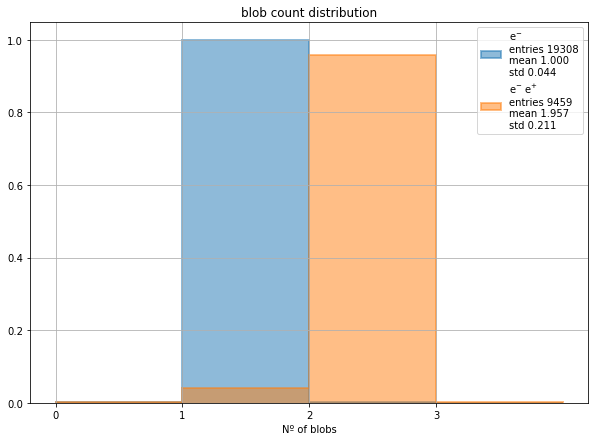

In [35]:
%matplotlib inline
plt.figure(figsize = (10, 7))
histogram_statistics(beersh_voxels, 'nblob', 'Nº of blobs', discrete_var=True, print_statistics=True)
plt.xticks(ticks = [0, 1, 2, 3])
plt.title('blob count distribution')
plt.show()

En este último histograma, el total de % no tiene ningún sentido rollo no nos da información :) O sea, sigue siendo el porcentaje total de eventos que tienen cierto número de blobs, pero no nos dá información de si están bien o mal (me refiero a que cuenta todos los eventos con 1 blob en el porcentaje, sin tener en cuenta si son de bkg o signal, por tanto es una información que no nos aporta nada)

In [36]:
blob_counting_false = beersh_voxels[(beersh_voxels.blob_success == False)][['dataset_id', 'binclass', 'nblob', 'blob_success']].drop_duplicates()
#[(beersh_voxels.binclass == 0) & (beersh_voxels.nblob != 1)]



In [37]:
len(blob_counting_false) / len(beersh_voxels.dataset_id.unique())

0.015573400076476519

e$^{-}$ [55.26315789  0.         44.73684211  0.        ]
e$^{-}$ e$^{+}$ [ 2.19512195 95.85365854  0.          1.95121951]
total [ 6.69642857 87.72321429  3.79464286  1.78571429]


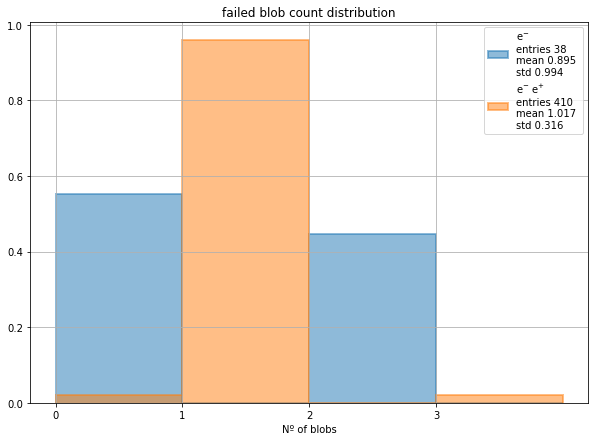

In [38]:
%matplotlib inline
plt.figure(figsize = (10, 7))
histogram_statistics(blob_counting_false, 'nblob', 'Nº of blobs', discrete_var=True, print_statistics=True)
plt.xticks(ticks = [0, 1, 2, 3])
plt.title('failed blob count distribution')
plt.show()

PERO en este útlimo histograma el total sí nos dá información :)

In [39]:
tot_evs = len(blob_counting_false.dataset_id.unique())
for i in (0, 1):
    for j in blob_counting_false.nblob.unique():
        event_list = blob_counting_false[(blob_counting_false.binclass == i) & (blob_counting_false.nblob == j)].dataset_id.unique()
        print('{} FAILED EVENTS ON COUNTING BLOBS, WITH BINCLASS {} AND {} BLOBS'.format(len(event_list), i, j))
        print(len(event_list) / tot_evs * 100)
        print(event_list)
        
        

0 FAILED EVENTS ON COUNTING BLOBS, WITH BINCLASS 0 AND 1 BLOBS
0.0
[]
17 FAILED EVENTS ON COUNTING BLOBS, WITH BINCLASS 0 AND 2 BLOBS
3.7946428571428568
[  996  1992  2526  5516  8723 14338 16853 18509 19382 22814 23829 24589
 25509 25848 25981 27223 27993]
21 FAILED EVENTS ON COUNTING BLOBS, WITH BINCLASS 0 AND 0 BLOBS
4.6875
[ 2572  5553  5967  6424  6464  8547  8860  9799 13176 15531 18647 18949
 20453 21215 21848 23358 23896 24126 25420 27691 27695]
0 FAILED EVENTS ON COUNTING BLOBS, WITH BINCLASS 0 AND 3 BLOBS
0.0
[]
393 FAILED EVENTS ON COUNTING BLOBS, WITH BINCLASS 1 AND 1 BLOBS
87.72321428571429
[   24    98   470   481   489   680   682   755   881  1010  1224  1244
  1355  1485  1525  1550  1572  1675  1690  1710  1797  1819  1843  1847
  1857  1914  1959  1975  2080  2372  2379  2455  2482  2488  2565  2595
  2675  2751  3203  3230  3308  3523  3764  3806  3821  3847  3937  3946
  3977  3986  4082  4087  4113  4216  4280  4317  4427  4548  4646  4728
  4767  4811  4819  4917

Ahora sería mirar los casos anteriores:

-- Binclass 0:
* 0 blobs: no sé que pasa
* 2 blobs: se separa por sabe dios q, mirar

-- Binclass 1:
* 0 blobs: se anikilan el e-e+
* 1 blobs: se unen los dos blobs
* 2 blob: se separa como binclass 0 con 2 blobs guesseo!!

e$^{-}$ [ 0.19680961 99.80319039]
e$^{-}$ e$^{+}$ [ 4.33449625 95.66550375]
total [ 1.55734001 98.44265999]


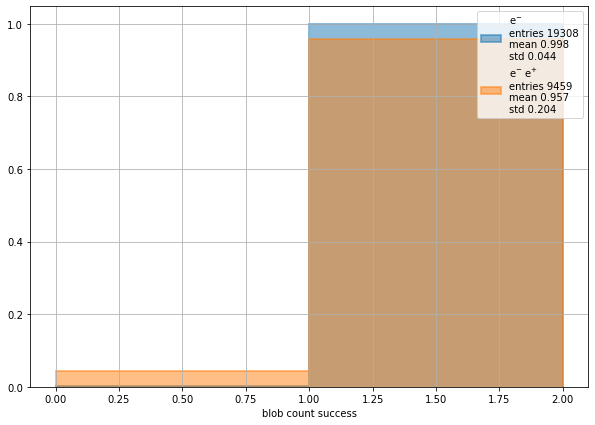

In [40]:
%matplotlib inline
plt.figure(figsize = (10, 7))
histogram_statistics(beersh_voxels, 'blob_success', 'blob count success', print_statistics=True)
plt.show()

Beersheba labelling statistics
Being "element" a group of voxels with the same labelling, and "cloud" a group of voxels that are clustered


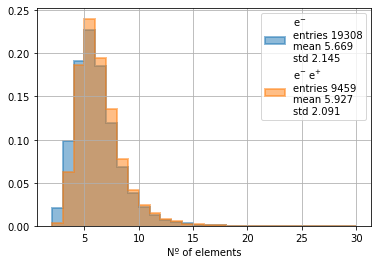

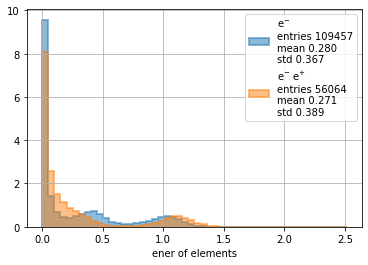

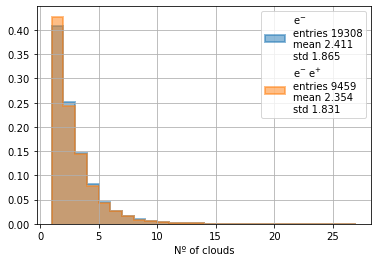

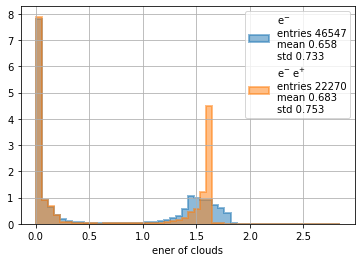

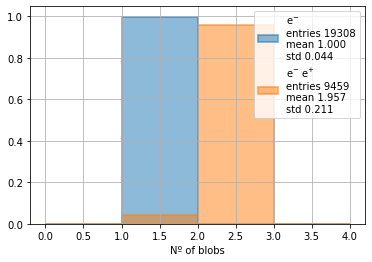

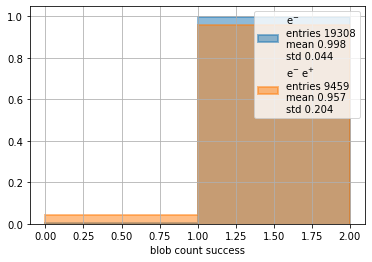

In [41]:
%matplotlib inline
variables = ['event_elem_count', 'elem_ener',        'cloud_count',  'cloud_ener',     'nblob',       'blob_success']
names     = ['Nº of elements',   'ener of elements', 'Nº of clouds', 'ener of clouds', 'Nº of blobs', 'blob count success']
discrete  = [True, False, True, False, True, True]

print('Beersheba labelling statistics')
print('Being "element" a group of voxels with the same labelling, and "cloud" a group of voxels that are clustered')
for (var, name), disc in zip(zip(variables, names), discrete):
    histogram_statistics(beersh_voxels, var, name, discrete_var = disc)
    plt.show()

The element grouping was a way to measure how good was my labelling. That is, if there is one group of voxels blob in an event, we can say that the event is background, and if there are two groups, signal. Of course this method is not perfect, but regarding the issue we are facing, this is probably the best approach.

The last histogram shows that the labelling was 100% accurate for bkg and 96% accurate for signal (twisted tracks that end up with both blobs nearby). The other histograms just give an overview on the composition of each event.

## Estadísticas de las isaura tracks

In [42]:
isaura_info_bin = isaura_info.merge(beersh_voxels[['dataset_id', 'binclass', 'nblob']].drop_duplicates(), on = ['dataset_id'])

In [43]:
blob2_cut = 0.2659 

In [44]:
isaura_info_bin = isaura_info_bin.assign(isau_binclass = isaura_info.eblob2 > blob2_cut)
isaura_info_bin.isau_binclass = isaura_info_bin.isau_binclass.astype('int')

In [45]:
isaura_main_bin = isaura_info_bin[isaura_info_bin.trackID == 0]

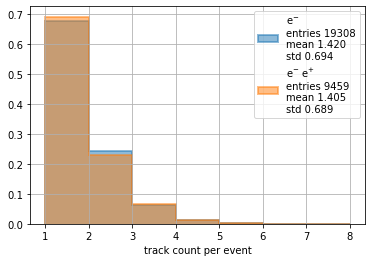

In [46]:
variables = ['numb_of_tracks']
names     = ['track count per event']

for var, name in zip(variables, names):
    histogram_statistics(isaura_info_bin, var, name)


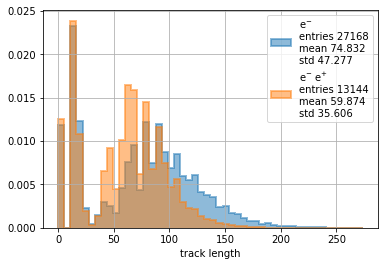

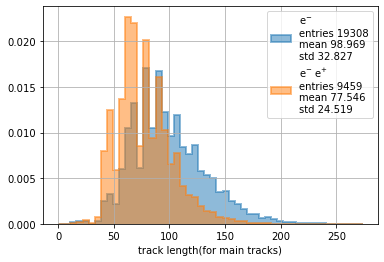

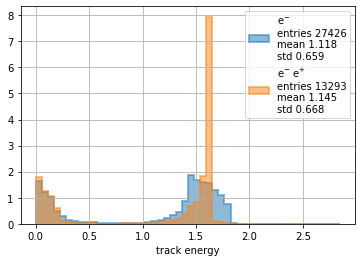

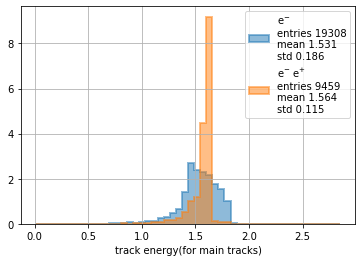

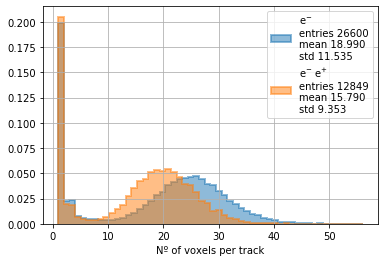

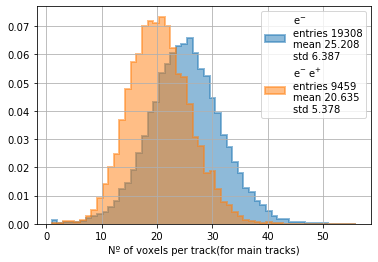

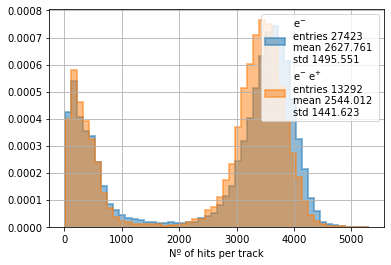

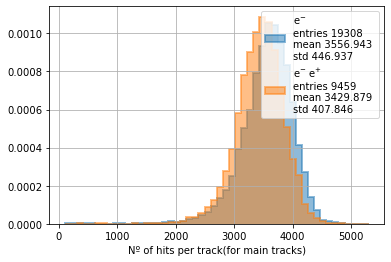

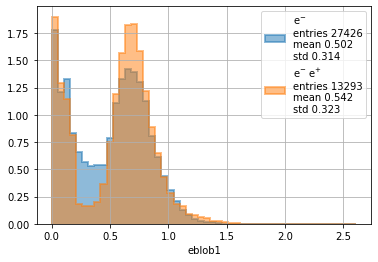

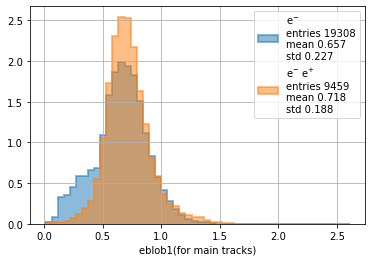

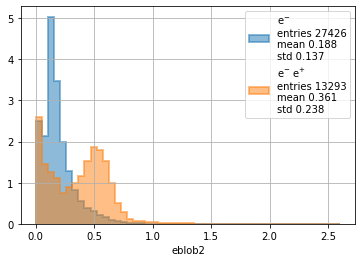

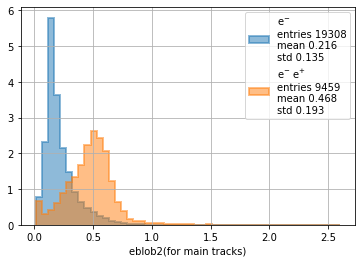

In [47]:
variables = ['length',       'energy',       'numb_of_voxels',         'numb_of_hits',         'eblob1', 'eblob2']
names     = ['track length', 'track energy', 'Nº of voxels per track', 'Nº of hits per track', 'eblob1', 'eblob2']

for var, name in zip(variables, names):
    histogram_statistics(isaura_info_bin, var, name)
    plt.show()
    histogram_statistics(isaura_main_bin,   var, name + '(for main tracks)')
    plt.show()

First we explore isaura important parameters for all the tracks, to see how it performed on the beersheba data. Also, we compare it with the same parameters for just the main track of each event.

## Estadísticas de la coincidencia entre isaura - labelling

Then, we explore the main tracks parameters, and the COINCIDENCE statistics. The coincidence was a method I performed to see how isaura and the labelling would match. If a isaura blob was placed within a certain radius near a labelled voxel, we would say that isaura certainly identified this blob correctly. Then, if one blob was identified we would say that the event is bkg, if two blobs were identified we would say that the event is signal. If no blob was identified, we would say that the event couldn't be classified.

Statistics for MAIN ISAURA TRACKS


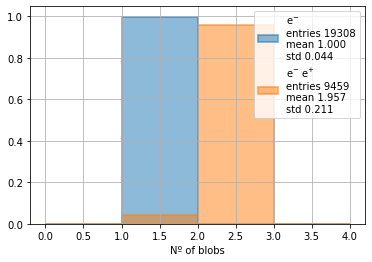

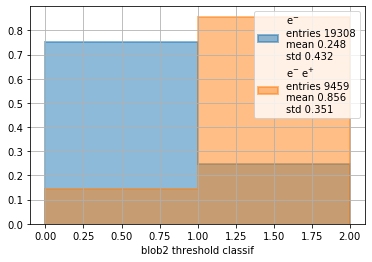

In [48]:
variables = [ 'nblob',       'isau_binclass',         ] #'bkg_coincidence',  'sig_coincidence',  'coincidence_binclass', 'start_track_coincidence']
names     = [ 'Nº of blobs', 'blob2 threshold classif'] #'is the track bkg', 'is the track sig', 'coincidence classif',  'start bkg track coincidence']

print('Statistics for MAIN ISAURA TRACKS')

for var, name in zip(variables, names):
    histogram_statistics(isaura_main_bin, var, name)
    plt.show()

In the previous histograms we can see firstly the nº of blobs (with the segmentation voxel counting), the blob2 threshold classification (from the isaura paper) and finally the coincidence results: if a track is bkg, if is signal, then how it was classified counting the non classified tracks as -1 (maybe this causes a histogram that doesn't give a lot of good information...). Finally, we do the same for the track start of the bkg events.

# Busqueda de centros de mis blobs...

Primero voy a ver si consigo ''compensar'' el hecho de que no está voxelizado igual en las 3 coordenadas :)

Por ejemplo voy a buscar el centro entre 2 puntos en 3D y luego voxelizar con distintos tamaños a ver como consigo encontrar dicho centro (no sé si tendré que "pesar" de alguna forma cada punto o así)

Creo que eso nanai, pero lo q si voy a hacer es probar a pesar por energías y a ver que pasa :)

In [49]:
def bin_transformer(x, y, z, bins_info):
    '''
    This function transforms the bins position into real coordinates.
    
    Args:
        x, y, z: ARRAY
    Each one is an array of positions of voxels.
        
        bins_info: pd.DataFrame
    Contains the information of the bins, stored in the labelled file.
    
    RETURNS:
        x, y, z: ARRAY
    Transformed positions.
    '''
    
    min_x, size_x = bins_info.min_x.values[0], bins_info.size_x.values[0]
    min_y, size_y = bins_info.min_y.values[0], bins_info.size_y.values[0]
    min_z, size_z = bins_info.min_z.values[0], bins_info.size_z.values[0]
    
    x = x * size_x + min_x
    y = y * size_y + min_y
    z = z * size_z + min_z
    
    return x, y, z

Hacer de esto una funcion si eso :)

In [51]:
bins = bin_creator(bins_info)

In [90]:
def get_centers(coords, energy):
    '''
    Args:
        coords: ARRAY
    Array with the 3 coordinates and shape (N, 3), being N the number of voxels.
    
        energy: ARRAY
    Array with the energy of each voxel.
    
    RETURNS:
        barycenter: ARRAY
    Contains the center weighted by energy.
    
        avg_center: ARRAY
    Contains the center.
    '''
    pondered_coords = [position * ener for position, ener in zip(coords, energy)]
    barycenter = sum(pondered_coords) / sum(energy)
    avg_center = sum(coords)/len(coords)
    
    return barycenter, avg_center

In [91]:
def get_blob_centers(beersh_voxels, bins_info):
    '''
    For each blob element, we transform the voxels into coordinates (to take into account the different
    sizes in each axis), we search for the center and barycenter (weighted in energy) and then revoxelize.
    
    Args:
        beersh_voxels: pd.DataFrame
    Contains all the beersheba labelled voxels information.
    
        bins_info: pd.DataFrame
    Contains the voxelization information of the labelled events.
    
    RETURNS:
        blob_center_df: pd.DataFrame
    Contains per event and per element the barycenter and the normal center.
    
    '''
    blob_center_df = pd.DataFrame()
    blob_segclass_name = [i for i in beersh_voxels.elem.unique() if i.split('_')[0] == '3']
    for (dat_id, elem), elem_df in beersh_voxels.groupby(['dataset_id', 'elem']):    
        if np.isin(elem, blob_segclass_name):
            binclass = elem_df.binclass.values[0]
            energy = elem_df.energy.values
            x, y, z = elem_df.xbin.values, elem_df.ybin.values, elem_df.zbin.values
            x, y, z = bin_transformer(x, y, z, bins_info)
            coords = np.array([x, y, z]).T
            
            barycenter, avg_center = get_centers(coords, energy)
        
            blob_center_df = blob_center_df.append({'dataset_id':dat_id, 
                                                    'binclass':binclass,
                                                    'elem':elem, 
                                                    'elem_ener': elem_df.elem_ener.values[0],
                                                    'elem_count': elem_df.elem_count.values[0],
                                                    'barycenter_x':barycenter[0], 
                                                    'barycenter_y':barycenter[1], 
                                                    'barycenter_z':barycenter[2],
                                                    'avg_center_x':avg_center[0], 
                                                    'avg_center_y':avg_center[1], 
                                                    'avg_center_z':avg_center[2]}, 
                                                    ignore_index=True)

    
    #aquí metería el caso en el que haya más de dos blobs!! son pocos casos pero bueno
    #bins = bin_creator(bins_info)
    #blob_center_df = voxelize_isaura_blobs(blob_center_df, bins, colposition = [0, 6])

    return blob_center_df



## Separación entre los blobs isaura y mis centros de labelling blob

In [92]:
def add_track_start_points(file):
    '''
    Function to extract from the MCHits DataFrame the starting point of a background track.
    
    Args:
        file: STR
    Path to the labelled file with the isaura information.
    
    RETURNS:
        isaura_info_start: pd.DataFrame
    Contains the isaura info and the track start (just for the background tracks)
    '''
    
    mchits = dio.load_dst(file, 'DATASET', 'MCHits')
    isaura_info = dio.load_dst(file, 'DATASET', 'IsauraInfo')
    
    track_start = mchits[(mchits.binclass == 0) & (mchits.segclass == 2) & (mchits.hit_id == 0)][['dataset_id', 'x', 'y', 'z']]
    
    track_start = track_start.rename({'x':'track_start_x', 'y':'track_start_y', 'z':'track_start_z'}, axis = 1)
    isaura_info_start = isaura_info.merge(track_start, on = 'dataset_id', how = 'outer')
    return isaura_info_start

In [93]:
isaura_info_start = add_track_start_points(file)

In [94]:
blob_center_df = get_blob_centers(beersh_voxels, bins_info)

In [95]:
isaura_info_blobs = isaura_info_start.merge(blob_center_df, on = 'dataset_id', how = 'outer')

if binclass == 0
* blob1 --> barycenter '3_0'
* blob2 --> track_start '3_0'

if binclass == 1
* blob1 --> barycenter '3_0'
* blob2 --> barycenter '3_1'

In [96]:
isaura_info_blobs = isaura_info_blobs[isaura_info_blobs.trackID == 0] #escogemos unicamente las trazas principales

In [100]:
isaura_info_blobs[isaura_info_blobs.track_start_x.notnull()]

array(['3_0', '3_1', nan], dtype=object)

In [104]:
def distance_to_center(centers_df, center_name, isaura_blob_name, coords = ['x', 'y', 'z']):
    '''
    Computes the distance between two points in a dataframe with a certain name.
    
    Args:
        centers_df: pd.DataFrame
    Contains per event and track the desired points information.
    
        center_name: STR
    Base name for the kind of point we want to compare (either 'track_start_' or 'barycenter_')
    
        isaura_blob_name: STR
    Base name for the isaura blob we want to compare(either 'blob1_' or 'blob2_')
    
    RETURNS:
        dist: FLOAT
    Distance between the desired points.
    '''
    
    center_coords = np.array([centers_df[center_name + c].values[0] for c in coords])
    isau_blob_coords = np.array([centers_df[isaura_blob_name + c].values[0] for c in coords])
    dist = np.linalg.norm(center_coords - isau_blob_coords)
    return dist

In [105]:
def recalculate_barycenter(centers_df, isaura_blob_name):
    '''
    Takes several elements and recalculates their barycenter weighted with the element energy.
    
    Args:
        centers_df: pd.DataFrame
    Contains per event and track the desired points information.
    
        isaura_blob_name: STR
    Base name for the isaura blob we want to compare(either 'blob1_' or 'blob2_')
    
    RETURNS:
        centers_df: pd.DataFrame
    Contains the desired isaura blob to compare and the new regrouped barycenter.
    '''
    coor = np.array([centers_df.barycenter_x.values, centers_df.barycenter_y.values, centers_df.barycenter_z.values]).T
    barycenter, avg_center = get_centers(coor, centers_df.elem_ener.values)
    centers_df = centers_df[[isaura_blob_name + 'x', 
                             isaura_blob_name + 'y', 
                             isaura_blob_name + 'z']].drop_duplicates().assign(**{'barycenter_x':barycenter[0],
                                                                                  'barycenter_y':barycenter[1],
                                                                                  'barycenter_z':barycenter[2]})
    return centers_df

In [102]:

def distance_cases(isaura_info_blobs):
    '''
    Different situations to know which two points to compare in each case. 
        If the event is bkg, the function takes all the blob elements and 
        combines them into one center to compare with blob1, and the blob2 
        is measured against the track start. 
        
        If the event is signal, the first element is compared to blob1 and 
        the second element (or the rest, if there are more than two elements) 
        are compared to blob2; if there's only one blob, both blob1&blob2 
        are compared to the same point (guessing that two elements grouped together)
    
    It is also computed the distance between blob1&2 and the oposite blob 
    elements, just in case my energetic blob is the isaura's less energetic 
    blob. After this output it will be chosen the best combination.
    
    The events where no blob element was found are not included here. 
    
    Args: 
        isaura_info_blobs: pd.DataFrame
    Contains the isaura main tracks information with all the track start + blob centers information
    
    RETURNS:
        dist_blob_df: 
    Contains the distances between the label and isaura blobs (both combinations).
    '''
    dist_blob_df = pd.DataFrame()

    for (idx, bincl, elem_count), centers_df in isaura_info_blobs.groupby(['dataset_id', 'binclass', 'elem_count']):
        eblob1, eblob2 = centers_df.eblob1.values[0], centers_df.eblob2.values[0]
        centers_df_inv = centers_df.copy()
        
        if bincl == 0:
            label_blob2_x = centers_df.track_start_x.values[0]
            label_blob2_y = centers_df.track_start_y.values[0]
            label_blob2_z = centers_df.track_start_z.values[0]
            
            #For bkg, the blob2 is always the track start
            blob2_dist = distance_to_center(centers_df, 'track_start_', 'blob2_')
            #I also compute the distance with crossed blobs, just in case the tables had turned for 
            #isaura; although this effect would be more relevant for the signal events
            blob1_dist_inv = distance_to_center(centers_df, 'track_start_', 'blob1_')
            
            if elem_count > 1:
                #If the bkg event happens to have more than one blob element, we recalculate the 
                #barycenter with all the elements
                centers_df = recalculate_barycenter(centers_df, 'blob1_')
                centers_df_inv = recalculate_barycenter(centers_df_inv, 'blob2_')
            
            #Finally, we compute the distance between the barycenter and the blob1
            blob1_dist = distance_to_center(centers_df, 'barycenter_', 'blob1_')
            #And the inverse
            blob2_dist_inv = distance_to_center(centers_df_inv, 'barycenter_', 'blob2_')
        
            label_blob1_x = centers_df.barycenter_x.values[0]
            label_blob1_y = centers_df.barycenter_y.values[0]
            label_blob1_z = centers_df.barycenter_z.values[0]

        
        if bincl == 1:
            
            label_blob1_x = centers_df[centers_df.elem == '3_0'].barycenter_x.values[0]
            label_blob1_y = centers_df[centers_df.elem == '3_0'].barycenter_y.values[0]
            label_blob1_z = centers_df[centers_df.elem == '3_0'].barycenter_z.values[0]

            blob1_dist = distance_to_center(centers_df[centers_df.elem == '3_0'], 'barycenter_', 'blob1_')
            blob2_dist_inv = distance_to_center(centers_df[centers_df.elem == '3_0'], 'barycenter_', 'blob2_')
            
            if elem_count < 2:
                #Blob1 and blob2 will be referred to the same element
                blob2_dist = distance_to_center(centers_df, 'barycenter_', 'blob2_')
                blob1_dist_inv = distance_to_center(centers_df, 'barycenter_', 'blob1_')
                
                label_blob2_x, label_blob2_y, label_blob2_z = label_blob1_x, label_blob1_y, label_blob1_z
                
            if elem_count == 2:
                blob2_dist = distance_to_center(centers_df[centers_df.elem == '3_1'], 'barycenter_', 'blob2_')
                blob1_dist_inv = distance_to_center(centers_df[centers_df.elem == '3_1'], 'barycenter_', 'blob1_')
                
                label_blob2_x = centers_df[centers_df.elem == '3_1'].barycenter_x.values[0]
                label_blob2_y = centers_df[centers_df.elem == '3_1'].barycenter_y.values[0]
                label_blob2_z = centers_df[centers_df.elem == '3_1'].barycenter_z.values[0]
                
            if elem_count > 2:
                #We get rid of the 3_0 element as it will only contribute to the blob1
                centers_df = centers_df[centers_df.elem != '3_0']
                centers_df = recalculate_barycenter(centers_df, 'blob2_')
                blob2_dist = distance_to_center(centers_df, 'barycenter_', 'blob2_')
                
                centers_df_inv = recalculate_barycenter(centers_df_inv, 'blob1_')
                blob1_dist_inv = distance_to_center(centers_df_inv, 'barycenter_', 'blob1_')
                
                label_blob2_x = centers_df.barycenter_x.values[0]
                label_blob2_y = centers_df.barycenter_y.values[0]
                label_blob2_z = centers_df.barycenter_z.values[0]
    
        dist_blob_df = dist_blob_df.append({'dataset_id':idx, 
                                            'binclass':bincl,
                                            'blob1_dist':blob1_dist,
                                            'blob2_dist':blob2_dist,
                                            'blob1_dist_inv':blob1_dist_inv,
                                            'blob2_dist_inv':blob2_dist_inv,
                                            'label_blob1_x':label_blob1_x, 
                                            'label_blob1_y':label_blob1_y, 
                                            'label_blob1_z':label_blob1_z, 
                                            'label_blob2_x':label_blob2_x, 
                                            'label_blob2_y':label_blob2_y, 
                                            'label_blob2_z':label_blob2_z,
                                            'eblob1':eblob1, 
                                            'eblob2':eblob2}, 
                                            ignore_index=True)

    return dist_blob_df


In [111]:
dist_blob_df = distance_cases(isaura_info_blobs)


In [120]:
dist_blob_df = take_best_dist_outcome(dist_blob_df)

In [116]:
def take_best_dist_outcome(dist_blob_df):
    '''
    Sums the two barycenter-isaurablob distances and picks up the minimum of both
    
    Args:
        dist_blob_df: pd.DataFrame
    Contains per event the combinations of blob distances between isaura and labelling.
    
    RETURNS:
        dist_blob_df: pd.DataFrame
    Contains per event the minimum distance combination between the barycenter of 
    labelled blobs and the isaura blobs. Also the binclass and the isaura blob energy.
    '''
    min_dist_mask = dist_blob_df.blob1_dist + dist_blob_df.blob2_dist < dist_blob_df.blob1_dist_inv + dist_blob_df.blob2_dist_inv
    normal_dist_df = dist_blob_df[min_dist_mask].drop(['blob1_dist_inv', 'blob2_dist_inv'], axis = 1)
    
    inv_dist_df = dist_blob_df[~min_dist_mask].drop(['blob1_dist', 'blob2_dist'], axis = 1)
    inv_dist_df = inv_dist_df.rename(columns={'blob1_dist_inv':'blob1_dist', 'blob2_dist_inv':'blob2_dist', 'eblob1':'eblob2', 'eblob2':'eblob1'})
    
    dist_blob_df = normal_dist_df.append(inv_dist_df).sort_values('dataset_id')
    
    return dist_blob_df
    

In [60]:
def get_dist_blob_isaura(file):
    '''
    Searchs for the barycenters of the blob elements in an event and performs 
    the whole distance comparison between the barycenters of the label blobs
    and the isaura blobs. 
    
    Args:
        file: STR
    Directory of the labelled data.
    
    RETURNS:
        dist_blob_df: pd.DataFrame
    Contains per event the minimum distance combination between the barycenter of 
    labelled blobs and the isaura blobs. Also the binclass and the isaura blob energy.
    
        isaura_info_blobs: pd.DataFrame
    Contains the isaura main track information with the barycenter and track start coordinates.
    
    '''
    beersh_voxels = dio.load_dst(file, 'DATASET', 'BeershebaVoxels')
    bins_info = dio.load_dst(file, 'DATASET', 'BinsInfo')
    
    isaura_info_start = add_track_start_points(file)
    blob_center_df = get_blob_centers(beersh_voxels, bins_info)
    
    isaura_info_blobs = isaura_info_start.merge(blob_center_df, on = 'dataset_id', how = 'outer')
    isaura_info_blobs = isaura_info_blobs[isaura_info_blobs.trackID == 0]
    
    dist_blob_df = distance_cases(isaura_info_blobs)
    dist_blob_df[['blob2_dist', 'eblob2']] = dist_blob_df.groupby('dataset_id')[['blob2_dist', 'eblob2']].fillna(method='bfill')
    dist_blob_df.drop_duplicates(inplace = True)
    dist_blob_df = take_best_dist_outcome(dist_blob_df)
    return dist_blob_df, isaura_info_blobs


In [121]:
#dist_blob_df, isaura_info_blobs = get_dist_blob_isaura(file)

# ISAURA DISTANCES

In [50]:
isaura_info = dio.load_dst(file, 'DATASET', 'IsauraInfo')

In [51]:
dist_blob_df, isaura_info_blobs = get_dist_blob_isaura(MC_hits, beersh_voxels, isaura_info, bins_info)

### OVERLAP VOLUME

Dos cosas para el overlap: 

* la primera es con la fórmula que ya conozco, que sería lo que se overlappean las esferas sin más
* la segunda es algo más parecido a lo que ya había hecho, pq cojo un punto, abro una esfera y miro qué voxeles caen dentro. esto ya lo hice, y a mayores sería mirar por cada evento (que tendrá dos esferas con voxeles dentro) cuántos voxeles coinciden respecto al total de voxeles que hay en las esferas. vamos, o eso pienso.

In [52]:
def get_overlap_volume(dist_blob_df, R):
    coords = ['x', 'y', 'z']
    label_blob1_coor = np.array([dist_blob_df['label_blob1_' + c].values for c in coords]).T
    label_blob2_coor = np.array([dist_blob_df['label_blob2_' + c].values for c in coords]).T

    d = np.linalg.norm(label_blob1_coor - label_blob2_coor, axis = 1)
    dist_blob_df = dist_blob_df.assign(dist_label_blob = d)
    
    V_sph = (4 / 3 * np.pi * R ** 3)
    vol_fun = lambda x: (np.pi * (4 * R + x) * (2 * R - x) ** 2) / (12 * V_sph) if x < 2 * R else 0
    
    dist_blob_df['ovl_vol'] = dist_blob_df['dist_label_blob'].apply(vol_fun)

    return dist_blob_df

Hay OBVIAMENTE varios eventos que tienen overlap total porque son signal events con 1 blob sólo, entonces se ponen ambos blobs al mismo!!

In [53]:
dist_blob_df

,binclass,blob1_dist,blob2_dist,dataset_id,eblob1,eblob2,label_blob1_x,label_blob1_y,label_blob1_z,label_blob2_x,label_blob2_y,label_blob2_z
0,0.0,21.838272,6.048958,0.0,0.663805,0.128549,126.922129,91.660967,429.648000,97.603165,121.327568,352.321014
1,1.0,4.025743,6.031244,1.0,0.778415,0.670538,-24.150508,-178.202725,464.042125,-25.817137,-119.520537,437.836873
2,1.0,10.829775,21.869283,2.0,1.004997,1.117782,26.182408,76.693720,391.943629,35.000000,100.000000,389.000000
3,0.0,10.563930,3.699977,3.0,0.868505,0.496368,-3.298883,-121.034030,268.215972,6.395124,-53.172501,251.060959
4,0.0,9.329180,53.961839,4.0,0.030906,0.136234,-115.843702,125.204983,384.030767,-121.919853,112.352142,327.705475
...,...,...,...,...,...,...,...,...,...,...,...,...
28732,1.0,5.709780,26.283354,28762.0,0.602088,0.035153,-2.508034,153.984158,249.750837,-35.000000,140.000000,277.000000
28733,1.0,33.452659,16.938881,28763.0,0.513715,0.261883,75.994262,-59.584775,282.196878,42.694365,-49.476111,233.049986
28734,1.0,4.610699,6.222973,28764.0,0.779280,0.602014,18.436500,156.604707,238.111381,5.328625,180.328625,265.000000
28735,1.0,19.605497,30.699185,28765.0,0.366401,0.644160,8.974102,-122.066683,54.474839,36.135927,-114.563069,61.908742


In [54]:
ovl_prop = []
ovl_mean = []
radius = np.arange(0, 40, 1)
for rad in radius:
    ovl_blob = get_overlap_volume(dist_blob_df, rad).ovl_vol
    ovl_mean = ovl_blob.mean()
    nevents = len(ovl_blob)
    nevents_ovl = sum(ovl_blob > 0)
    ovl_prop.append(nevents_ovl / nevents)


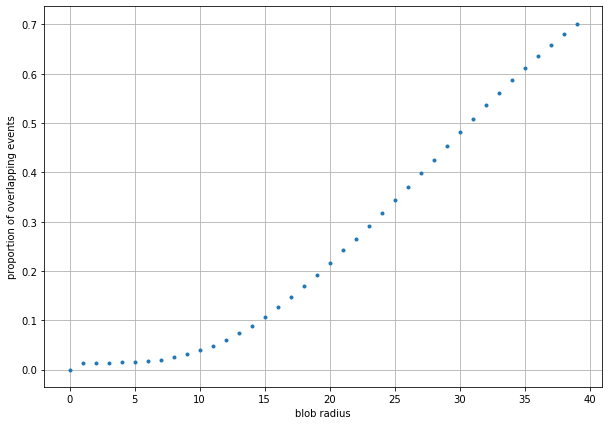

In [55]:
plt.figure(figsize = (10, 7))
plt.plot(radius, ovl_prop, '.')
plt.xlabel('blob radius')
plt.ylabel('proportion of overlapping events')
plt.grid()

In [56]:
original_dist_blob_df = dist_blob_df.copy()

In [57]:
sum(dist_blob_df.eblob1 > dist_blob_df.eblob2) / len(dist_blob_df)

#number of times the isaura blob1 had greater energy than the isaura blob2 (from isaura information!!)
#now is only 80% bc ive preferred to take as blobs the closest to another blob and not by their energy

0.8007446845530153

In [58]:
len(dist_blob_df) / dist_blob_df.dataset_id.max()
#number of tracks that had representation (those that had no blobs are not represented here)

0.9989918653966489

In [59]:
dist_blob_df = dist_blob_df[~dist_blob_df.blob1_dist.isnull()]

Porcentaje de trazas q no tienen elementos blob y por tanto quedan fuerite

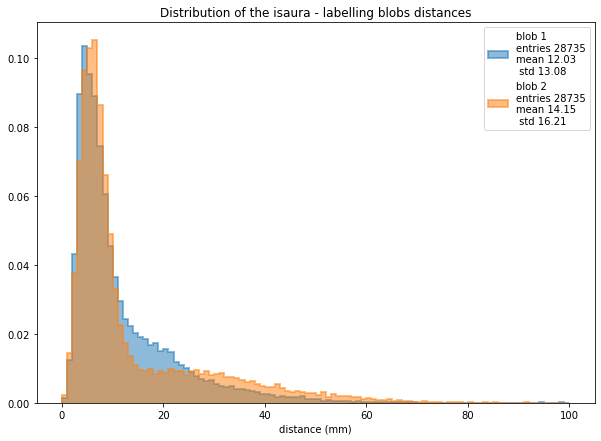

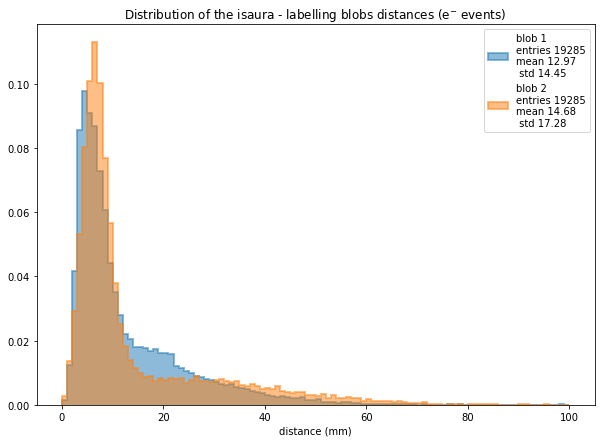

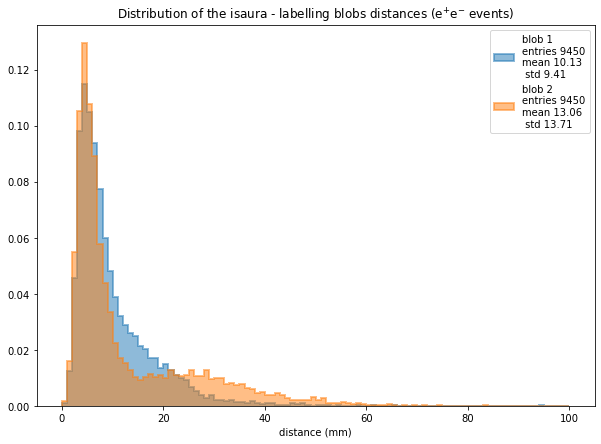

In [62]:
%matplotlib inline

var_name = ['blob1_dist', 'blob2_dist']
event_name = ['e$^{-}$', 'e$^{+}$e$^{-}$']
nbins = 100
for i in (1, 2):
    plt.figure(3, figsize = (10, 7))
    plot_df = dist_blob_df[var_name[i -1]]
    plt.hist(plot_df, 
             range = (0, nbins), 
             bins = nbins, 
             histtype = 'step', 
             label = 'blob {:.0f}\nentries {:.0f}\nmean {:.2f}\n std {:.2f}'.format(i, len(plot_df), np.mean(plot_df), np.std(plot_df)), 
             density = True, alpha = 0.5, fill = True, linewidth = 2)
    plt.legend()
    plt.title('Distribution of the isaura - labelling blobs distances')
    plt.xlabel('distance (mm)')
    
    for binclass in (0, 1):
        plt.figure(binclass, figsize = (10, 7))
        plot_df = dist_blob_df[dist_blob_df.binclass == binclass][var_name[i -1]]
        plt.hist(plot_df, 
                 range = (0, nbins), 
                 bins = nbins, 
                 histtype = 'step', 
                 label = 'blob {:.0f}\nentries {:.0f}\nmean {:.2f}\n std {:.2f}'.format(i, len(plot_df), np.mean(plot_df), np.std(plot_df)), 
                 density = True, alpha = 0.5, fill = True, linewidth = 2)
        plt.title('Distribution of the isaura - labelling blobs distances ({} events)'.format(event_name[binclass]))
        plt.xlabel('distance (mm)')
        plt.legend()
    

plt.show()

In [ ]:
histtype = 'step', label = var.split('_')[0] + info, density = True, 
                              alpha = 0.5, fill = True, linewidth = 2

In [48]:
def both_blobs_acc(dist_df, radius):
    total_evs = len(dist_df)
    acc = [len(dist_df[(dist_df.blob1_dist < i) & (dist_df.blob2_dist < i)]) / total_evs for i in radius]
    return acc

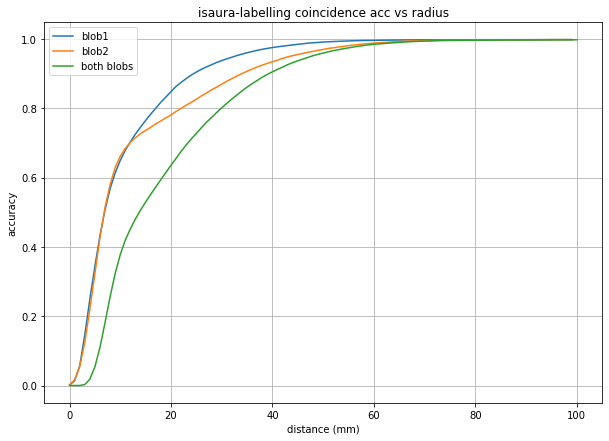

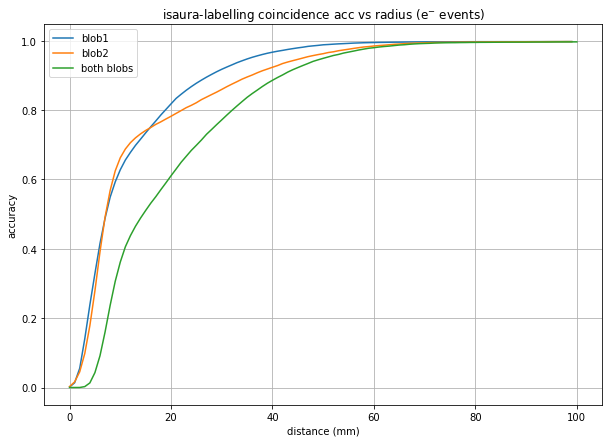

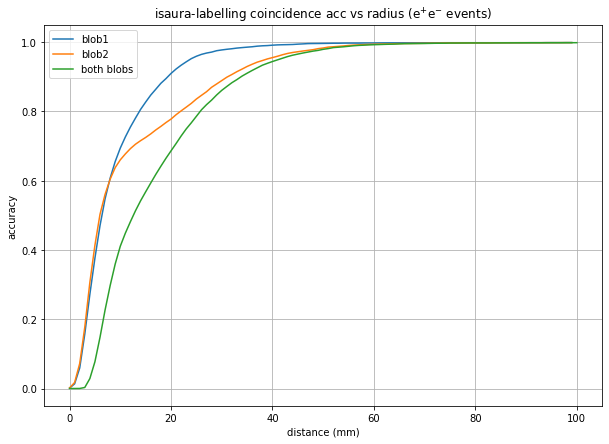

In [451]:
%matplotlib inline

num_events = len(dist_blob_df)

nbin = 100

var_name = ['blob1_dist', 'blob2_dist']
event_name = ['e$^{-}$', 'e$^{+}$e$^{-}$']

    
for i in (1, 2):
    plt.figure(3, figsize = (10, 7))
    hist, hbins = np.histogram(dist_blob_df[var_name[i - 1]], range = (0, nbin), bins = nbin)
    
    num_events = len(dist_blob_df)
    acc = hist.cumsum() / num_events
    plt.plot(hbins[:-1], acc, '-', label = 'blob' + str(i))
    plt.xlabel('distance (mm)')
    plt.ylabel('accuracy')
    plt.title('isaura-labelling coincidence acc vs radius')
    plt.grid(visible = True)
    plt.legend()
    
    for binclass in (0, 1):
        plt.figure(binclass, figsize = (10, 7))
        hist, hbins = np.histogram(dist_blob_df[dist_blob_df.binclass == binclass][var_name[i-1]], 
                                  range = (0, nbin), 
                                  bins = nbin)
        
        num_events = len(dist_blob_df[dist_blob_df.binclass == binclass])
        acc = hist.cumsum() / num_events
        plt.plot(hbins[:-1], acc, '-', label = 'blob' + str(i))
        plt.xlabel('distance (mm)')
        plt.ylabel('accuracy')
        plt.title('isaura-labelling coincidence acc vs radius ({} events)'.format(event_name[binclass]))
        plt.grid(visible = True)
        plt.legend()

#Accuracy for both blobs

plt.figure(3, figsize = (10, 7))
total_acc = both_blobs_acc(dist_blob_df, hbins)
plt.plot(hbins, total_acc, label = 'both blobs')
plt.legend()

plt.figure(0, figsize = (10, 7))
bkg_acc = both_blobs_acc(dist_blob_df[dist_blob_df.binclass == 0], hbins)
plt.plot(hbins, bkg_acc, label = 'both blobs')
plt.legend()

plt.figure(1, figsize = (10, 7))
sig_acc = both_blobs_acc(dist_blob_df[dist_blob_df.binclass == 1], hbins)
plt.plot(hbins, sig_acc, label = 'both blobs')
plt.legend()

In [453]:
print(sig_acc[20])

0.6862433862433862


In [454]:
print(bkg_acc[20])

0.6106300233341976


## Ver cómo se clasifican los voxeles de isaura que quedan fuera del radio con mis blobs

## Primero vemos TODOS los voxeles, indep de si están dentro o fuera de un radio :)

Bueno, tener en cuenta que para los eventos de fondo, el blob2 TIENE que ser traza, y no blob, pq se corresponde con el inicio de la traza!!!

In [50]:
def voxelize_isaura_blobs(isaura_info, bins, colposition = [26, 32]):
    '''
    bins es [bins_x, bins_y, bins_z]
    
    THE FILLNA SHOULD BE AVOIDED... (by exceeding the limits in the z position when voxelizing!!)
    '''
    for colname, bi in zip(isaura_info.columns[colposition[0]:colposition[1]], bins * 2):
        isaura_bin = pd.cut(isaura_info[colname], bi, labels = np.arange(0, len(bi)-1)).fillna(0).astype(int)
        isaura_info = isaura_info.assign(**{colname + 'bin' : isaura_bin})
        
    return isaura_info

In [51]:
def identify_isaura_blobs_class(isaura_voxels, beersh_voxels, coord_names = ['xbin', 'ybin', 'zbin']):
    '''
    Matches the blob labelled beersheba voxels with the isaura voxels (voxelized isaura blob centres)
    Also, if a blob centre doesn't have any match, we search for it in an sphere of certain radius
    '''
    
    blob_voxels = beersh_voxels[['dataset_id', 'xbin', 'ybin', 'zbin', 'segclass', 'elem']]
    
    
    for name in ['blob1', 'blob2']:
        center_names = [name + '_xbin', name + '_ybin', name + '_zbin']
        blob_segname, blob_elename = name + '_seg', name + '_ele'
        
        isaura_voxels = isaura_voxels.merge(blob_voxels, 
                                            left_on = ['dataset_id'] + center_names, 
                                            right_on = ['dataset_id'] + coord_names, 
                                            how = 'left').drop(['xbin', 'ybin', 'zbin'], 
                                                               axis = 1).rename(columns = {'segclass':blob_segname, 
                                                                                           'elem':blob_elename})
            
    return isaura_voxels

In [52]:
def classify_isaura_voxels(isaura_info, beersh_voxels, bins):
    isaura_voxels = voxelize_isaura_blobs(isaura_info, bins)
    isaura_voxels = identify_isaura_blobs_class(isaura_voxels, beersh_voxels)
    return isaura_voxels

In [53]:
bins = bin_creator(bins_info)

In [54]:
isaura_voxels_bin = classify_isaura_voxels(isaura_info_bin, beersh_voxels, bins)

In [55]:
isaura_voxels_main_bin = isaura_voxels_bin[isaura_voxels_bin.trackID == 0]

In [56]:
class_dict = {1:1, 2:2, 3:3, 4:1, 5:2, 6:3, 7:4, np.nan:5}

In [57]:
def plot_isaura_blobs(isaura_blob_df_, class_dict):
    
    total_hist_info = []
    variable = ['blob1_seg', 'blob2_seg']
    
    isaura_blob_df = isaura_blob_df_.copy()
    isaura_blob_df[variable[0]] = isaura_blob_df[variable[0]].map(class_dict)
    isaura_blob_df[variable[1]] = isaura_blob_df[variable[1]].map(class_dict)
    
    xrange = (isaura_blob_df[variable].min().min(), isaura_blob_df[variable].max().max() + 1)
    nbins = int(xrange[1] - xrange[0])
    print(xrange, nbins)
    
    for var in variable:
        series_plot = isaura_blob_df[var]
    
        info = '\nentries {}'.format(len(series_plot))
        hist_info = plt.hist(series_plot, bins = nbins, 
                              range = xrange, histtype = 'step', label = var.split('_')[0] + info, density = True, 
                              alpha = 0.5, fill = True, linewidth = 2)
        print(hist_info[0])
        total_hist_info.append([len(series_plot), hist_info[0]])
    plt.xticks(ticks = [1.5, 2.5, 3.5, 4.5, 5.5], labels = ['other', 'track', 'blob', 'ghost', 'NaN'], fontsize = 12)
    plt.legend(fontsize = 12)
    plt.xlabel('segmentation class')
    
    print('total', sum([data[0] * data[1] for data in total_hist_info]) / sum([data[0] for data in total_hist_info]) * 100)
    plt.grid()

A continuación ploteo para dos datasets (todas las trazas de isaura + sólo las trazas principales), en 3 casos distintos: todos sus tracks, los tracks de bkg y los de señal. Es importante separar ya que en bkg buscamos que el blob2 caiga en track, y el blob1 en blob, a direrencia de la señal que queremos que ambos caigan en blob. Bien es cierto que el hecho de que el blob2 de bkg caiga en track no nos dá información real de si está cerca del origen de la traza o no!!!!

(1, 6) 5
[0.34165869 0.32036641 0.32574474 0.00695007 0.00528009]
[0.38478352 0.50602913 0.09622044 0.0075886  0.00537832]
total [36.32211007 41.31977701 21.0982588   0.72693337  0.53292075]


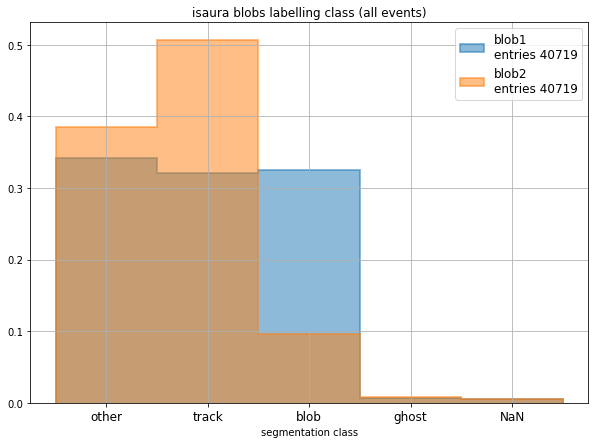

(1, 6) 5
[0.35036097 0.28790199 0.34904835 0.00718297 0.00550572]
[0.39874572 0.56964195 0.01819441 0.00787574 0.00554219]
total [37.45533435 42.87719682 18.36213812  0.75293517  0.55239554]


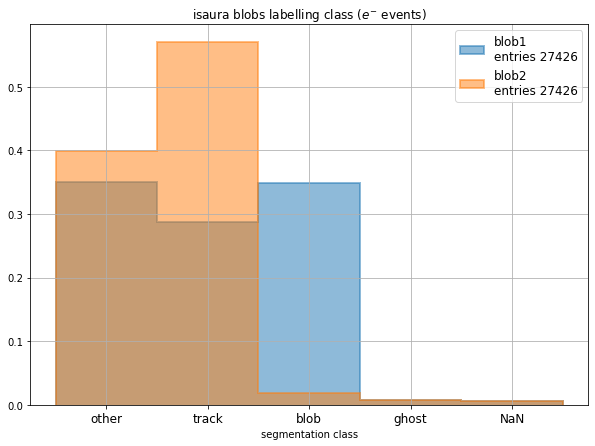

(1, 6) 5
[0.32370421 0.38734672 0.27766494 0.00646957 0.00481456]
[0.35597683 0.37478372 0.25720304 0.00699616 0.00504025]
total [33.98405176 38.10652223 26.74339878  0.67328669  0.49274054]


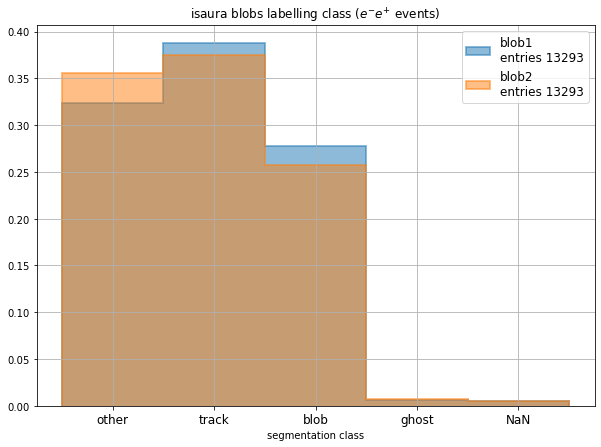

(1, 6) 5
[8.34984531e-02 4.51698126e-01 4.60388640e-01 2.43334376e-04
 4.17144645e-03]
[1.45270623e-01 7.14429729e-01 1.35641534e-01 2.43334376e-04
 4.41478083e-03]
total [1.14384538e+01 5.83063927e+01 2.98015087e+01 2.43334376e-02
 4.29311364e-01]


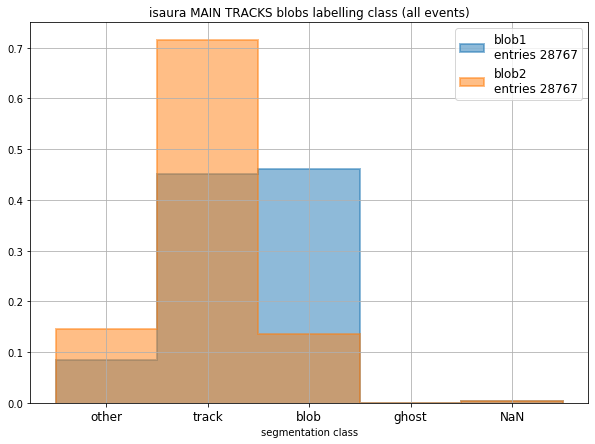

(1, 6) 5
[9.34845660e-02 4.06619018e-01 4.95183344e-01 2.58960017e-04
 4.45411229e-03]
[1.62730474e-01 8.06712244e-01 2.55852496e-02 3.10752020e-04
 4.66128030e-03]
total [1.28107520e+01 6.06665631e+01 2.60384297e+01 2.84856018e-02
 4.55769629e-01]


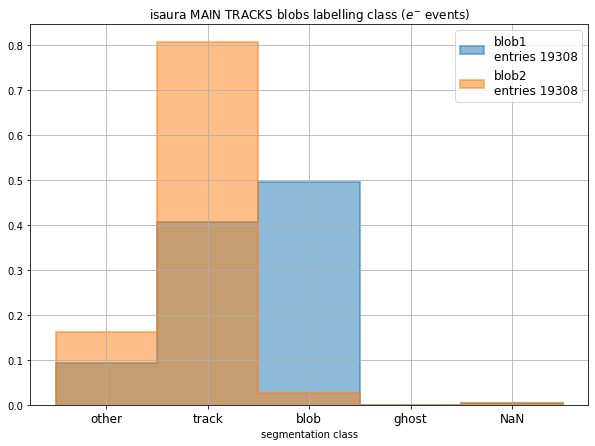

(1, 6) 5
[6.31144941e-02 5.43714980e-01 3.89364626e-01 2.11438841e-04
 3.59446030e-03]
[1.09631039e-01 5.26059837e-01 3.60291786e-01 1.05719421e-04
 3.91161856e-03]
total [8.63727667e+00 5.34887409e+01 3.74828206e+01 1.58579131e-02
 3.75303943e-01]


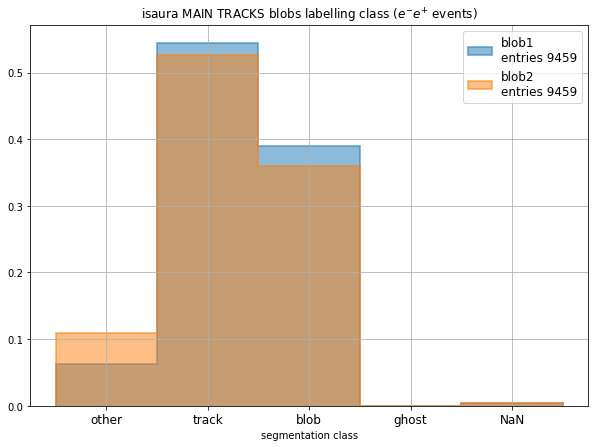

In [58]:
%matplotlib inline


plt.figure(figsize = (10, 7))
plot_isaura_blobs(isaura_voxels_bin, class_dict)
plt.title('isaura blobs labelling class (all events)')
plt.show()

plt.figure(figsize = (10, 7))
plot_isaura_blobs(isaura_voxels_bin[isaura_voxels_bin.binclass == 0], class_dict)
plt.title('isaura blobs labelling class ($e^{-}$ events)')
plt.show()

plt.figure(figsize = (10, 7))
plot_isaura_blobs(isaura_voxels_bin[isaura_voxels_bin.binclass == 1], class_dict)
plt.title('isaura blobs labelling class ($e^{-}e^{+}$ events)')
plt.show()

plt.figure(figsize = (10, 7))
plot_isaura_blobs(isaura_voxels_main_bin, class_dict)
plt.title('isaura MAIN TRACKS blobs labelling class (all events)')
plt.show()

plt.figure(figsize = (10, 7))
plot_isaura_blobs(isaura_voxels_main_bin[isaura_voxels_main_bin.binclass == 0], class_dict)
plt.title('isaura MAIN TRACKS blobs labelling class ($e^{-}$ events)')
plt.show()

plt.figure(figsize = (10, 7))
plot_isaura_blobs(isaura_voxels_main_bin[isaura_voxels_main_bin.binclass == 1], class_dict)
plt.title('isaura MAIN TRACKS blobs labelling class ($e^{-}e^{+}$ events)')
plt.show()

In [445]:
2.55852496e-02

0.0255852496

Lo siguiente a mirar será la clasificación de los blobs de isaura para aquellas trazas donde NO se consiguió acertar la posición (dentro de cierto radio obviamente). 

En principio voy a escoger las trazas que NO tuvieron ambos blobs dentro del radio, es decir que puede que haya muchos eventos que tengan un blob acertado y el otro no...

Lo que se me ocurre es o hacer eso, o hacer dos df (uno por cada blob, rollo df donde los eventos tienen el blob1 fuera, y otro igual para el blob2), y luego del blob1 SÓLO ver las etiquetas del blob1, e igualmente para blob2

### BLOBS OUT OF THE RADIUS (INDEPENDENTLY OF THE EVENT, JUST EVERY BLOB THAT FALLS OUT OF IT)

In [59]:
rad_cut = 20

In [60]:
def get_outside_radius_tracks(dist_df, isaura_voxels_main, radius_cut):
    '''
    For a certain radius, using the distance dataframe, it returns the isaura tracks PER BLOB that
    have the blob outside a radius originating in my barycenters/trackstart.
    Per blob specification is needed because one track may have just one blob laying inside the radius
    '''
    out_radius_blob1 = dist_df[dist_df.blob1_dist > radius_cut] 
    out_radius_blob2 = dist_df[dist_df.blob2_dist > radius_cut]
    
    isaura_out_radius_blob1 = isaura_voxels_main[np.isin(isaura_voxels_main.dataset_id, 
                                                         out_radius_blob1.dataset_id.unique())]
    isaura_out_radius_blob2 = isaura_voxels_main[np.isin(isaura_voxels_main.dataset_id, 
                                                         out_radius_blob2.dataset_id.unique())]
    return isaura_out_radius_blob1, isaura_out_radius_blob2

In [61]:
def plot_isaura_blobs_per_blob(isaura_blob_df_, class_dict):
    
    total_hist_info = []
    variable = ['blob1_seg', 'blob2_seg']
    
    isaura_blob_df = (isaura_blob_df_[0].copy(), isaura_blob_df_[1].copy())
    
    isaura_blob_df[0][variable[0]] = isaura_blob_df[0][variable[0]].map(class_dict)
    isaura_blob_df[0][variable[1]] = isaura_blob_df[0][variable[1]].map(class_dict)
    isaura_blob_df[1][variable[0]] = isaura_blob_df[1][variable[0]].map(class_dict)
    isaura_blob_df[1][variable[1]] = isaura_blob_df[1][variable[1]].map(class_dict)
    
    xrange = (min(isaura_blob_df[0][variable].min().min(), isaura_blob_df[1][variable].min().min()), 
              max(isaura_blob_df[0][variable].max().max(), isaura_blob_df[1][variable].max().max()) + 1)
    
    nbins = int(xrange[1] - xrange[0])
    print(xrange, nbins)
    
    for var, df in zip(variable, isaura_blob_df):
        series_plot = df[var]
        
        info = '\nentries {}'.format(len(series_plot))
        hist_info = plt.hist(series_plot, bins = nbins, 
                              range = xrange, histtype = 'step', label = var.split('_')[0] + info, density = True, 
                              alpha = 0.5, fill = True, linewidth = 2)
        print(hist_info[0])
        total_hist_info.append([len(series_plot), hist_info[0]])
    plt.xticks(ticks = [1.5, 2.5, 3.5, 4.5, 5.5], labels = ['other', 'track', 'blob', 'ghost', 'NaN'], fontsize = 12)
    plt.legend(fontsize = 12)
    plt.xlabel('segmentation class')
    
    print('total', sum([data[0] * data[1] for data in total_hist_info]) / sum([data[0] for data in total_hist_info]) * 100)
    plt.grid()

In [62]:
out_blob1, out_blob2 = get_outside_radius_tracks(dist_blob_df, isaura_voxels_main_bin, rad_cut)

(1, 6) 5
[0.21180628 0.76720017 0.01309499 0.00083143 0.00706714]
[0.38321614 0.59813513 0.01024152 0.00061143 0.00779578]
total [31.05787017 66.97789131  1.14507179  0.07046596  0.74870078]


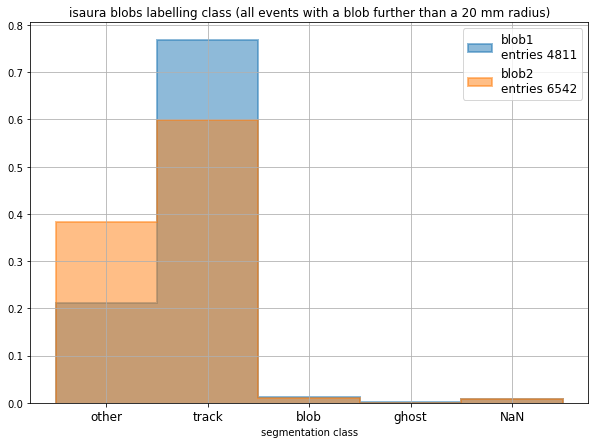

(1, 6) 5
[0.2203301  0.7555672  0.01598114 0.00078596 0.0073356 ]
[0.39917222 0.57806392 0.01471603 0.00068981 0.00735801]
total [31.55767818 66.10335538  1.5307372   0.07347539  0.73475386]


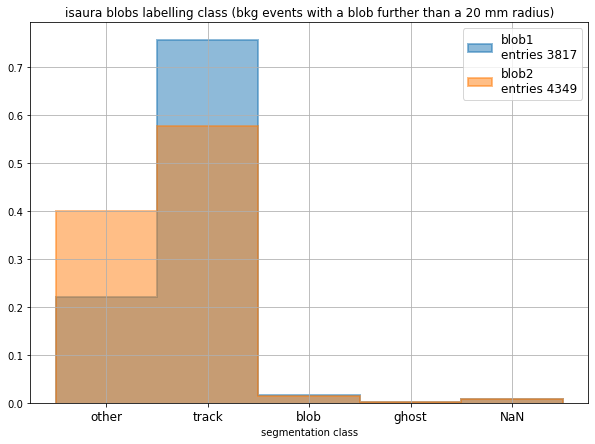

(1, 6) 5
[0.17907445 0.81187123 0.00201207 0.00100604 0.00603622]
[3.51573187e-01 6.37938896e-01 1.36798906e-03 4.55996352e-04
 8.66393069e-03]
total [2.97772200e+01 6.92187010e+01 1.56887355e-01 6.27549420e-02
 7.84436774e-01]


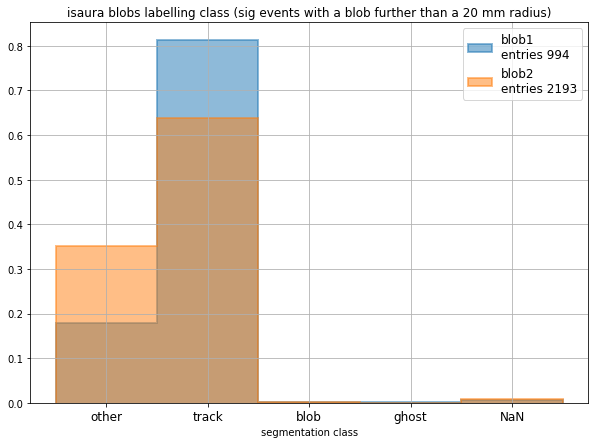

In [63]:
plt.figure(figsize = (10, 7))
plot_isaura_blobs_per_blob((out_blob1, out_blob2), class_dict)
plt.title('isaura blobs labelling class (all events with a blob further than a {} mm radius)'.format(rad_cut))
plt.show()

plt.figure(figsize = (10, 7))
plot_isaura_blobs_per_blob((out_blob1[out_blob1.binclass == 0], out_blob2[out_blob2.binclass == 0]), class_dict)
plt.title('isaura blobs labelling class (bkg events with a blob further than a {} mm radius)'.format(rad_cut))
plt.show()

plt.figure(figsize = (10, 7))
plot_isaura_blobs_per_blob((out_blob1[out_blob1.binclass == 1], out_blob2[out_blob2.binclass == 1]), class_dict)
plt.title('isaura blobs labelling class (sig events with a blob further than a {} mm radius)'.format(rad_cut))
plt.show()

### EVENTS WITH BOTH BLOBS OUT OF THE RADIUS

In [64]:
#Los eventos que tienen ambos blobs FUERA del radio
both_blob_out = out_blob1[np.isin(out_blob1.dataset_id.unique(), out_blob2.dataset_id)]

(1, 6) 5
[0.25255973 0.72696246 0.01478953 0.00113766 0.00455063]
[0.52332196 0.44482366 0.02047782 0.00341297 0.00796359]
total [38.79408419 58.58930603  1.76336746  0.22753129  0.62571104]


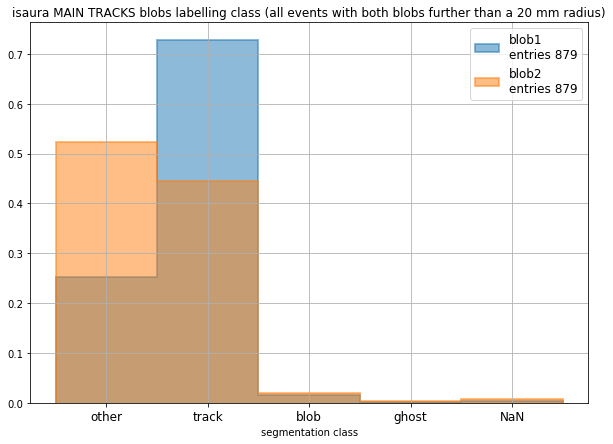

(1, 6) 5
[0.25570776 0.72146119 0.01674277 0.00152207 0.00456621]
[0.49315068 0.47031963 0.02587519 0.00304414 0.00761035]
total [37.44292237 59.5890411   2.13089802  0.2283105   0.60882801]


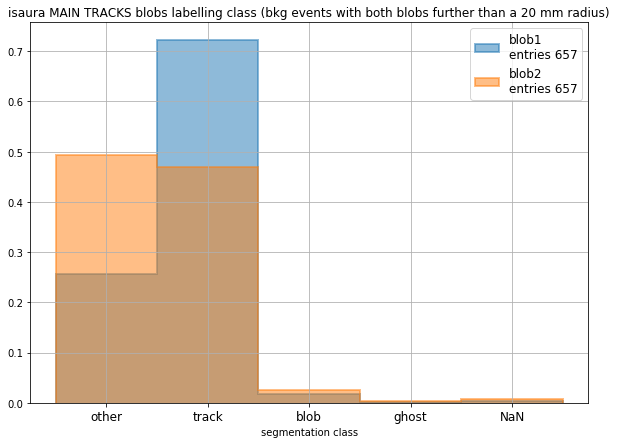

(1, 6) 5
[0.24324324 0.74324324 0.00900901 0.         0.0045045 ]
[0.61261261 0.36936937 0.0045045  0.0045045  0.00900901]
total [42.79279279 55.63063063  0.67567568  0.22522523  0.67567568]


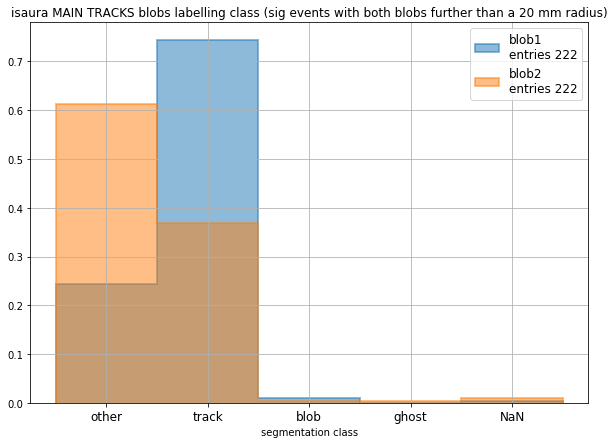

In [65]:
plt.figure(figsize = (10, 7))
plot_isaura_blobs(both_blob_out, class_dict)
plt.title('isaura MAIN TRACKS blobs labelling class (all events with both blobs further than a {} mm radius)'.format(rad_cut))
plt.show()

plt.figure(figsize = (10, 7))
plot_isaura_blobs(both_blob_out[both_blob_out.binclass == 0], class_dict)
plt.title('isaura MAIN TRACKS blobs labelling class (bkg events with both blobs further than a {} mm radius)'.format(rad_cut))
plt.show()

plt.figure(figsize = (10, 7))
plot_isaura_blobs(both_blob_out[both_blob_out.binclass == 1], class_dict)
plt.title('isaura MAIN TRACKS blobs labelling class (sig events with both blobs further than a {} mm radius)'.format(rad_cut))
plt.show()

El NUMERO TOTAL de eventos que tienen uno o ambos blobs fuera del radio sería la suma de los que tienen el blob1, el blob2 y restarle los coincidentes es decir both blob out

In [66]:
def plot_outblobs(dist_blob_df, isaura_voxels_main, rad_cut, class_dict):
    '''
    Plots 2 different cases (every blob outside a certain radius and just the blobs of events where
    both blobs were outside a certain radius), and for each case plots the bkg ones, sig ones and both, 
    divided each one in blob1 and blob2.
    '''
    out_blob1, out_blob2 = get_outside_radius_tracks(dist_blob_df, isaura_voxels_main, rad_cut)

    f = plt.figure(figsize = (20, 5))
    f.suptitle('isaura MAIN TRACKS blobs labelling (further than {} mm distance)'.format(rad_cut), fontsize = 15)
    f.add_subplot(1, 3, 1)
    plot_isaura_blobs_per_blob((out_blob1, out_blob2), class_dict)
    plt.title('All events, all blobs')
    print('--------')

    f.add_subplot(1, 3, 2)
    plot_isaura_blobs_per_blob((out_blob1[out_blob1.binclass == 0], out_blob2[out_blob2.binclass == 0]), class_dict)
    plt.title('Bkg events, all blobs')
    print('--------')
    
    f.add_subplot(1, 3, 3)
    plot_isaura_blobs_per_blob((out_blob1[out_blob1.binclass == 1], out_blob2[out_blob2.binclass == 1]), class_dict)
    plt.title('Sig events, all blobs')
    print('--------')
    '''
    f.add_subplot(2, 3, 4)
    both_blob_out = out_blob1[np.isin(out_blob1.dataset_id.unique(), out_blob2.dataset_id)]
    plot_isaura_blobs(both_blob_out, class_dict)
    plt.title('All events with both blobs out')
    print('--------')

    f.add_subplot(2, 3, 5)
    plot_isaura_blobs(both_blob_out[both_blob_out.binclass == 0], class_dict)
    plt.title('Bkg events with both blobs out')
    print('--------')

    f.add_subplot(2, 3, 6)
    plot_isaura_blobs(both_blob_out[both_blob_out.binclass == 1], class_dict)
    plt.title('Sig events with both blobs out')
    print('--------')
    '''
    
    plt.show()

(1, 6) 5
[1.03101386e-01 5.51944741e-01 3.39576283e-01 1.85434148e-04
 5.19215614e-03]
[1.62492746e-01 7.55725191e-01 7.63805187e-02 2.23204321e-04
 5.17834025e-03]
total [1.33357591e+01 6.55758210e+01 2.05494406e+01 2.04675703e-02
 5.18511780e-01]
--------
(1, 6) 5
[1.14151521e-01 5.00238241e-01 3.79960520e-01 2.04206657e-04
 5.44551086e-03]
[1.67108419e-01 8.07017544e-01 2.03836930e-02 2.52429635e-04
 5.23791493e-03]
total [1.41631463e+01 6.59429544e+01 1.93371975e+01 2.29230114e-02
 5.33778695e-01]
--------
(1, 6) 5
[7.95058140e-02 6.62354651e-01 2.53343023e-01 1.45348837e-04
 4.65116279e-03]
[1.51334859e-01 6.31731503e-01 2.11746758e-01 1.52555301e-04
 5.03432494e-03]
total [1.14551544e+01 6.47413472e+01 2.33048009e+01 1.48864905e-02
 4.83810942e-01]
--------


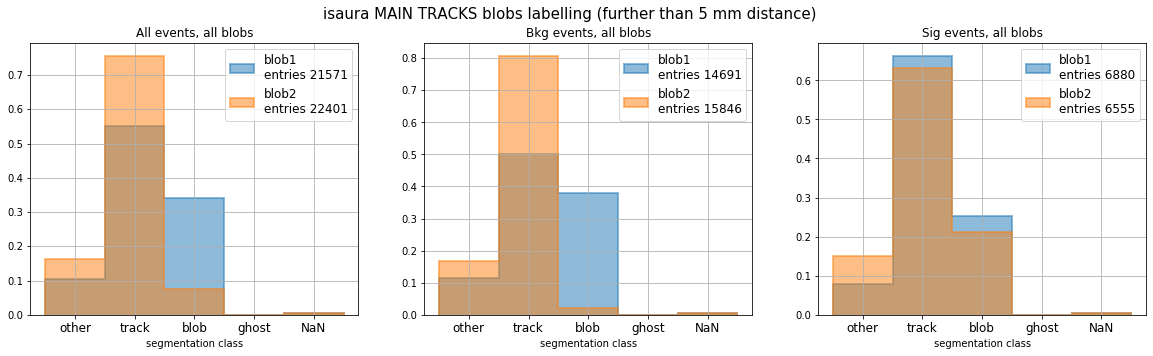

(1, 6) 5
[1.62089149e-01 7.50652859e-01 7.89734354e-02 3.60198109e-04
 7.92435840e-03]
[2.83355226e-01 6.89059861e-01 2.01726403e-02 4.69131169e-04
 6.94314130e-03]
total [2.21476818e+01 7.20488903e+01 5.01769058e+00 4.13545927e-02
 7.44382668e-01]
--------
(1, 6) 5
[1.79745223e-01 7.12229299e-01 9.97452229e-02 3.82165605e-04
 7.89808917e-03]
[2.92939063e-01 6.76523421e-01 2.34903966e-02 5.52715213e-04
 6.49440376e-03]
total [2.34042553e+01 6.95101743e+01 6.31669649e+00 4.63975608e-02
 7.22476304e-01]
--------
(1, 6) 5
[1.19508449e-01 8.43317972e-01 2.88786482e-02 3.07219662e-04
 7.98771121e-03]
[2.63080970e-01 7.15580240e-01 1.31540485e-02 2.92312189e-04
 7.89242911e-03]
total [1.93079688e+01 7.77860995e+01 2.08208508e+00 2.99580587e-02
 7.93888556e-01]
--------


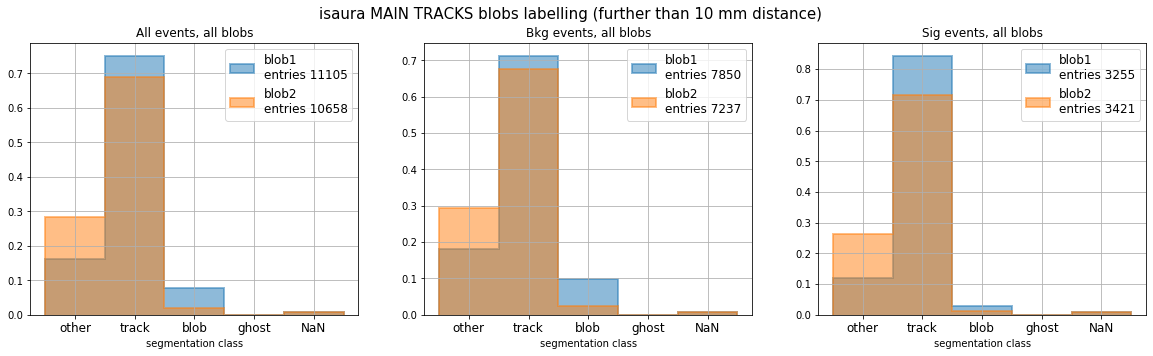

(1, 6) 5
[1.91375770e-01 7.71526352e-01 2.87474333e-02 5.47570157e-04
 7.80287474e-03]
[3.49484929e-01 6.25842554e-01 1.69146636e-02 5.08711688e-04
 7.24914155e-03]
total [2.73338608e+01 6.96004747e+01 2.26133966e+00 5.27426160e-02
 7.51582278e-01]
--------
(1, 6) 5
[2.07457503e-01 7.46298666e-01 3.71047341e-02 5.48345823e-04
 8.59075123e-03]
[3.68238022e-01 6.00656878e-01 2.37635240e-02 5.79598145e-04
 6.76197836e-03]
total [2.85620363e+01 6.75495445e+01 3.06189537e+00 5.63539025e-02
 7.70170001e-01]
--------
(1, 6) 5
[1.43402399e-01 8.46782988e-01 3.81679389e-03 5.45256270e-04
 5.45256270e-03]
[3.13360625e-01 6.74358020e-01 3.72162263e-03 3.72162263e-04
 8.18756978e-03]
total [2.44414952e+01 7.44304357e+01 3.76023004e-01 4.42380004e-02
 7.07808007e-01]
--------


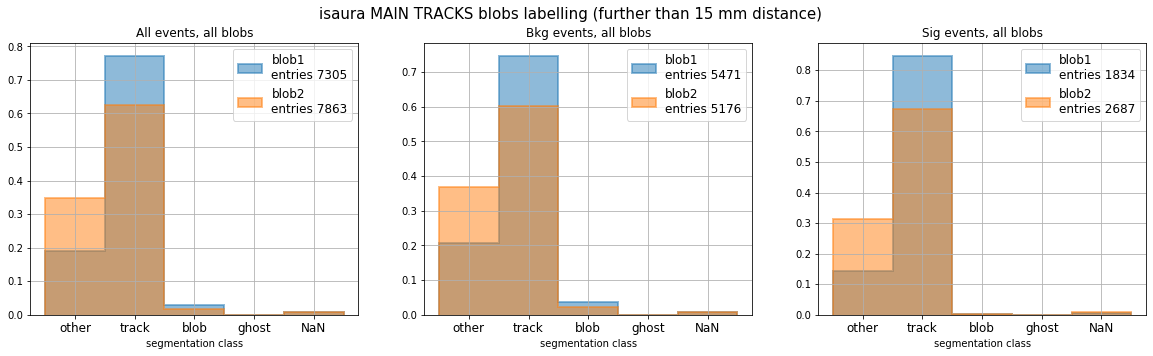

(1, 6) 5
[0.21180628 0.76720017 0.01309499 0.00083143 0.00706714]
[0.38321614 0.59813513 0.01024152 0.00061143 0.00779578]
total [31.05787017 66.97789131  1.14507179  0.07046596  0.74870078]
--------
(1, 6) 5
[0.2203301  0.7555672  0.01598114 0.00078596 0.0073356 ]
[0.39917222 0.57806392 0.01471603 0.00068981 0.00735801]
total [31.55767818 66.10335538  1.5307372   0.07347539  0.73475386]
--------
(1, 6) 5
[0.17907445 0.81187123 0.00201207 0.00100604 0.00603622]
[3.51573187e-01 6.37938896e-01 1.36798906e-03 4.55996352e-04
 8.66393069e-03]
total [2.97772200e+01 6.92187010e+01 1.56887355e-01 6.27549420e-02
 7.84436774e-01]
--------


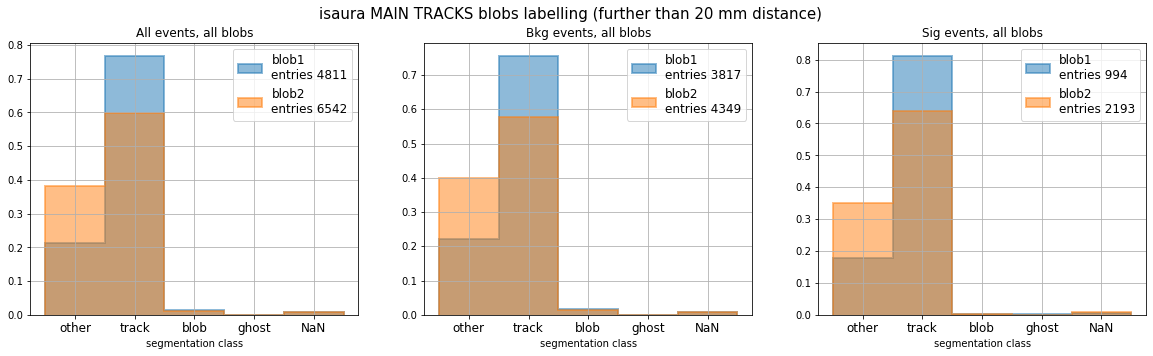

(1, 6) 5
[0.2305639  0.75809142 0.00500501 0.001001   0.00533867]
[0.41338658 0.57330291 0.00456361 0.0007606  0.00798631]
total [34.70203488 64.03827519  0.47238372  0.08478682  0.70251938]
--------
(1, 6) 5
[0.22871714 0.75990585 0.00549235 0.00078462 0.00510004]
[0.42172702 0.5632312  0.00668524 0.00083565 0.00752089]
total [34.15865776 64.48933051  0.61899332  0.08144649  0.65157192]
--------
(1, 6) 5
[0.24107143 0.74776786 0.00223214 0.00223214 0.00669643]
[0.39544638 0.59496705 0.         0.00059916 0.00898742]
total [3.62777515e+01 6.27302787e+01 4.72366556e-02 9.44733113e-02
 8.50259802e-01]
--------


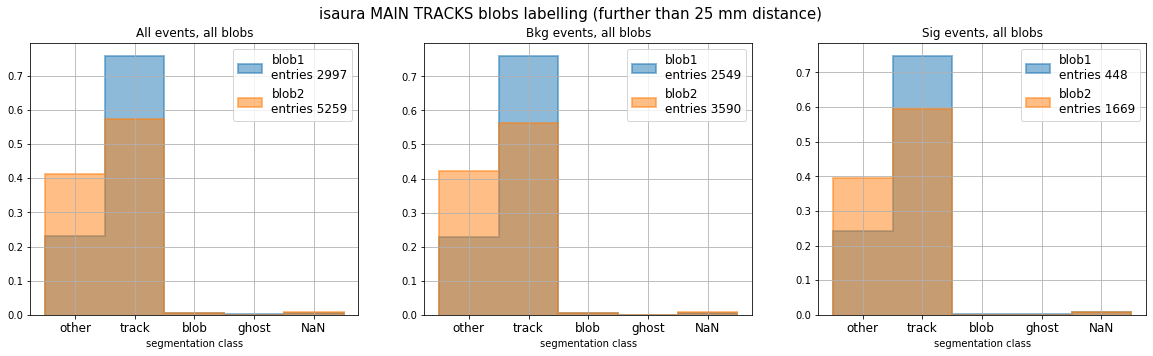

(1, 6) 5
[0.25038402 0.74295955 0.00256016 0.0015361  0.00256016]
[0.45204107 0.53618833 0.00300526 0.00075131 0.00801402]
total [38.58055836 60.41035991  0.28590649  0.10090817  0.62226707]
--------
(1, 6) 5
[0.24288205 0.75014526 0.00290529 0.00116212 0.00290529]
[0.44358795 0.54309741 0.00420463 0.00070077 0.00840925]
total [36.80874317 62.09836066  0.3715847   0.08743169  0.63387978]
--------
(1, 6) 5
[0.30603448 0.68965517 0.         0.00431034 0.        ]
[0.47322212 0.51887621 0.         0.00087796 0.00702371]
total [44.49307075 54.77753465  0.          0.14587892  0.58351568]
--------


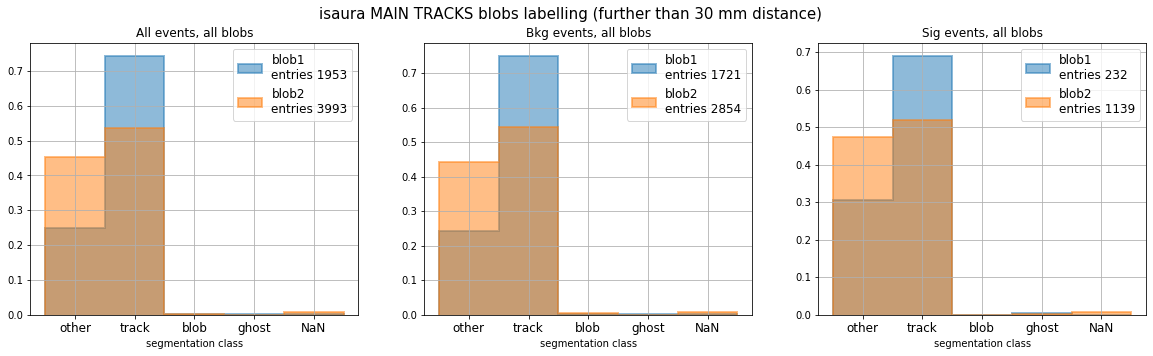

(1, 6) 5
[0.27936508 0.71269841 0.0031746  0.0015873  0.0031746 ]
[4.82217573e-01 5.05578801e-01 1.74337517e-03 3.48675035e-04
 1.01115760e-02]
total [42.03003876 56.87984496  0.21802326  0.07267442  0.7994186 ]
--------
(1, 6) 5
[0.27133872 0.71967655 0.00359389 0.00179695 0.00359389]
[4.52202437e-01 5.34208060e-01 2.34301781e-03 4.68603561e-04
 1.07778819e-02]
total [39.02063443 59.77825685  0.27717893  0.09239298  0.8315368 ]
--------
(1, 6) 5
[0.34013605 0.65986395 0.         0.         0.        ]
[0.56948229 0.42234332 0.         0.         0.00817439]
total [53.12145289 46.19750284  0.          0.          0.68104427]
--------


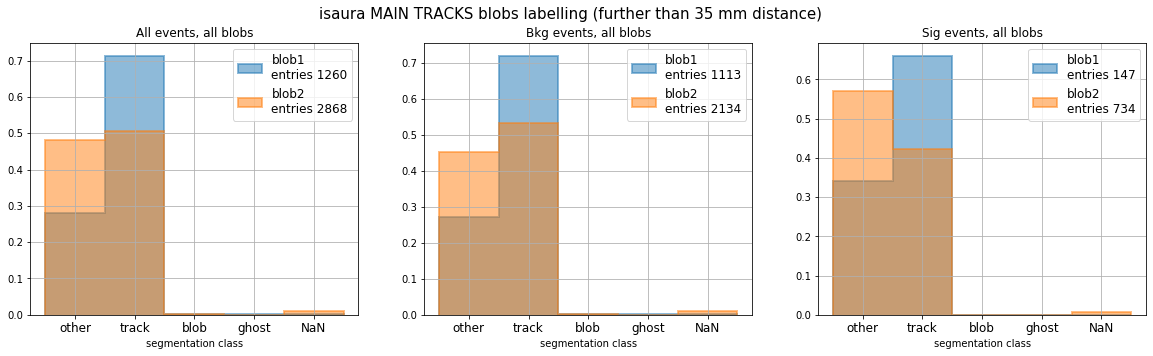

(1, 6) 5
[0.31592357 0.67388535 0.00509554 0.00254777 0.00254777]
[4.99259990e-01 4.86433152e-01 1.97335964e-03 4.93339911e-04
 1.18401579e-02]
total [44.80796586 53.87624467  0.28449502  0.10668563  0.92460882]
--------
(1, 6) 5
[0.3030303  0.68542569 0.00577201 0.002886   0.002886  ]
[0.4665818  0.51750477 0.00254615 0.00063654 0.01273074]
total [41.65194346 56.89045936  0.35335689  0.13250883  0.97173145]
--------
(1, 6) 5
[0.41304348 0.58695652 0.         0.         0.        ]
[0.61184211 0.37938596 0.         0.         0.00877193]
total [57.84671533 41.42335766  0.          0.          0.72992701]
--------


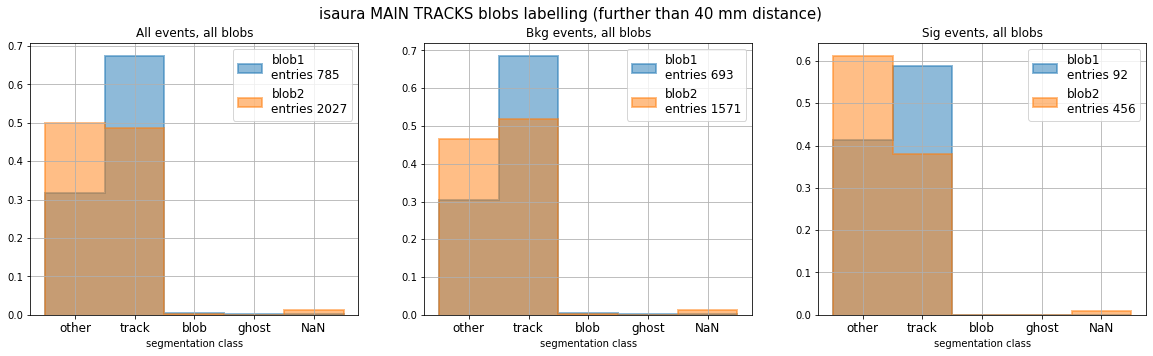

In [67]:
for rad in np.arange(5, 45, 5):
    plot_outblobs(dist_blob_df, isaura_voxels_main_bin, rad, class_dict)

Coger el VOXEL MÁS ENERGÉTICO Y REPETIR EL PROCESO (EN LUGAR DEL BARICENTRO)... ver que no cambia mucho si eso

## Barycenters

In [68]:
%matplotlib notebook
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def plot_centers(blob_center_df, beersh_voxels, bins_info, isaura_info, dataset_id, elem):
    elem_voxels = beersh_voxels[(beersh_voxels.dataset_id == dataset_id) & (beersh_voxels.elem == elem)]
    centers = blob_center_df[(blob_center_df.dataset_id == dataset_id) & (blob_center_df.elem == elem)]
    
    x, y, z = elem_voxels.xbin.values, elem_voxels.ybin.values, elem_voxels.zbin.values
    x, y, z = bin_transformer(x, y, z, bins_info)
    energy  = elem_voxels.energy.values
    
    barycenter = (centers.barycenter_x.values[0], centers.barycenter_y.values[0], centers.barycenter_z.values[0])
    avg_center = (centers.avg_center_x.values[0], centers.avg_center_y.values[0], centers.avg_center_z.values[0])
    
    #barycenter_bin = (centers.barycenter_xbin.values[0], centers.barycenter_ybin.values[0], centers.barycenter_zbin.values[0])
    #avg_center_bin = (centers.avg_center_xbin.values[0], centers.avg_center_ybin.values[0], centers.avg_center_zbin.values[0])
    
    #Los centros en bineado pasar a coordenada normal (pero en bin, no es lo mismo que la coordenada exacta
    # de los centros directamente!!)
    barycenter_bin = bin_transformer(barycenter_bin[0], barycenter_bin[1], barycenter_bin[2], bins_info)
    avg_center_bin = bin_transformer(avg_center_bin[0], avg_center_bin[1], avg_center_bin[2], bins_info)
    
    #print(barycenter, barycenter_bin)
    
    fig = plt.figure(figsize = (7, 7))
    ax = plt.axes(projection='3d')
    ax.scatter3D(x, y, z, c = energy, cmap=cm.cool, s = 100)
    ax.scatter3D(barycenter[0], barycenter[1], barycenter[2], s = 100, c = 'g', marker = '*')
    ax.scatter3D(avg_center[0], avg_center[1], avg_center[2], s = 100, c = 'r', marker = '*')
    
    ax.scatter3D(barycenter_bin[0], barycenter_bin[1], barycenter_bin[2], s = 100, c = 'g', marker = 'v')
    ax.scatter3D(avg_center_bin[0], avg_center_bin[1], avg_center_bin[2], s = 100, c = 'r', marker = 'v')
    
    if elem == '3_0':
        isau_names = ['blob1_x', 'blob1_y', 'blob1_z']
    if elem == '3_1':
        isau_names = ['blob2_x', 'blob2_y', 'blob2_z']
    
    isaura_blob = isaura_info[isaura_info.dataset_id == dataset_id][isau_names]
    ax.scatter3D(isaura_blob[isau_names[0]], isaura_blob[isau_names[1]], isaura_blob[isau_names[2]], s = 100, c = 'k', marker = '*')
    
    

In [87]:
#136, '3_1' diferencia entre centro normal y baricentro

In [87]:
#plot_centers(blob_center_df, beersh_voxels, bins_info, isaura_main_bin, 138, '3_0')


In [70]:
voxel_size = (bins_info.size_x.values[0], bins_info.size_y.values[0], bins_info.size_z.values[0])
start_bin  = (bins_info.min_x.values[0], bins_info.min_y.values[0], bins_info.min_z.values[0])

In [71]:
def recalculate_barycenter2(centers_df):
    '''
    Takes several elements and recalculates their barycenter weighted with the element energy
    '''
    coor = np.array([centers_df.barycenter_x.values, centers_df.barycenter_y.values, centers_df.barycenter_z.values]).T
    barycenter, avg_center = get_centers(coor, centers_df.elem_ener.values)
    centers_df = centers_df.drop(['barycenter_x', 
                                  'barycenter_y', 
                                  'barycenter_z'], axis = 1).assign(**{'barycenter_x':barycenter[0],
                                                                        'barycenter_y':barycenter[1],
                                                                        'barycenter_z':barycenter[2]})
    return centers_df

In [72]:
dataset_id = 4961

In [74]:
event_beersh_vox = beersh_voxels[beersh_voxels.dataset_id == dataset_id]
event_MC_hits = MC_hits[MC_hits.dataset_id == dataset_id]
event_isau_track = isaura_main_bin[isaura_main_bin.dataset_id == dataset_id]

In [80]:
event_blobs = isaura_info_blobs[isaura_info_blobs.dataset_id == dataset_id]

In [81]:
if event_blobs.binclass.values[0] == 0:
    if event_blobs.elem_count.values[0] > 1:
        event_blobs = recalculate_barycenter2(event_blobs[event_blobs.elem == '3_0'])
            
if event_blobs.binclass.values[0] == 1:
    if event_blobs.elem_count.values[0] > 2:
        event_blobs0 = event_blobs[event_blobs.elem == '3_0']
        event_blobs1 = recalculate_barycenter2(event_blobs[event_blobs.elem != '3_0'])
        event_blobs = event_blobs0.append(event_blobs1)

In [88]:
isaura_info_blobs

,dataset_id,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,...,avg_center_x,avg_center_y,avg_center_z,barycenter_x,barycenter_y,barycenter_z,binclass,elem,elem_count,elem_ener
0,0,10000005,0,1.639494,100.980762,22,3023,1,94.5,78.5,...,127.631579,92.105263,430.263158,126.922129,91.660967,429.648000,0.0,3_0,1.0,0.616199
1,1,10000006,0,1.605715,96.961524,19,3650,2,-37.5,-186.5,...,-23.448276,-180.517241,463.896552,-24.150508,-178.202725,464.042125,1.0,3_0,2.0,0.329266
2,1,10000006,0,1.605715,96.961524,19,3650,2,-37.5,-186.5,...,-24.642857,-118.214286,438.714286,-25.817137,-119.520537,437.836873,1.0,3_1,2.0,0.178242
5,2,10000007,0,1.320216,36.213203,8,3013,2,14.5,75.5,...,24.761905,75.000000,392.047619,26.182408,76.693720,391.943629,1.0,3_0,2.0,0.173940
6,2,10000007,0,1.320216,36.213203,8,3013,2,14.5,75.5,...,35.000000,100.000000,389.000000,35.000000,100.000000,389.000000,1.0,3_1,2.0,0.038020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53448,28764,118000620,0,1.487437,51.961524,15,3172,4,-8.5,145.5,...,18.250000,158.000000,237.800000,18.436500,156.604707,238.111381,1.0,3_0,2.0,0.277634
53449,28764,118000620,0,1.487437,51.961524,15,3172,4,-8.5,145.5,...,7.500000,182.500000,265.000000,5.328625,180.328625,265.000000,1.0,3_1,2.0,0.066215
53456,28765,118000621,0,1.597364,55.980762,20,3239,1,2.5,-141.5,...,6.842105,-120.000000,54.894737,8.974102,-122.066683,54.474839,1.0,3_0,2.0,0.154085
53457,28765,118000621,0,1.597364,55.980762,20,3239,1,2.5,-141.5,...,38.333333,-113.333333,63.666667,36.135927,-114.563069,61.908742,1.0,3_1,2.0,0.026282


In [82]:
event_blobs

,dataset_id,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,...,avg_center_x,avg_center_y,avg_center_z,barycenter_x,barycenter_y,barycenter_z,binclass,elem,elem_count,elem_ener
9269,4961,100000128,0,1.606734,47.193966,18,4076,1,19.5,-131.5,...,27.115385,-104.038462,263.153846,29.225081,-105.304523,263.243124,1.0,3_0,1.0,0.422823


In [83]:
def coord_transformer(coor, voxel_size, start_bin):
    new_coor = [(co - star) / siz for co, (siz, star) in zip(coor, zip(voxel_size, start_bin))]
    return new_coor

<IPython.core.display.Javascript object>


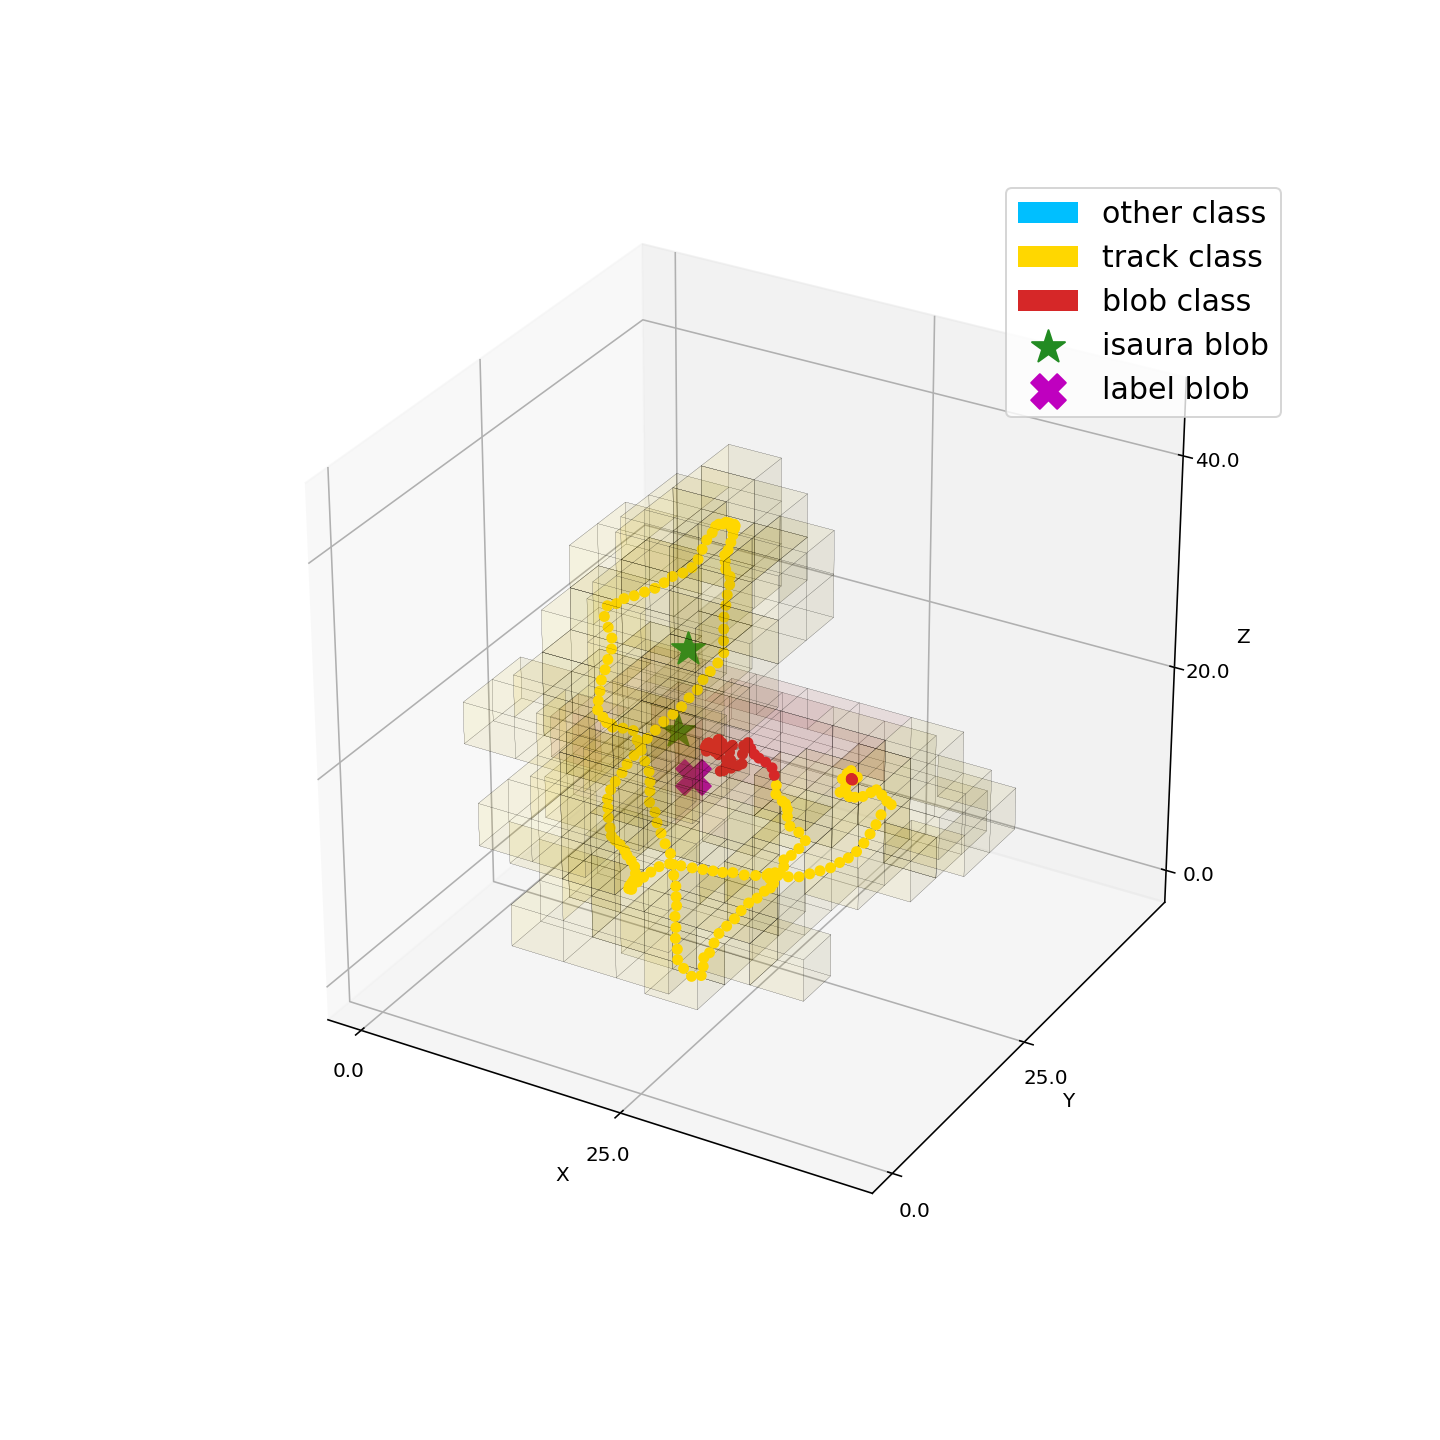

In [86]:
plot_cloud_voxels_and_hits_discrete_blobs(event_beersh_vox, event_MC_hits, event_blobs, voxel_size, start_bin, linewidth = 0.05, opacity = [0.05, 0.05, 1])




In [103]:
def plot_cloud_voxels_and_hits_discrete_blobs(labelled_voxels, labelled_hits, event_blobs, voxel_size, start_bin, affluence = (5, 5, 5), value = ['segclass', 'segclass', 'segclass'], coords = ['xbin', 'ybin', 'zbin'], coords_mc = ['x', 'y', 'z'], th=0, edgecolor='k', linewidth = .3, cmap = [mpl.cm.coolwarm, mpl.cm.coolwarm, mpl.cm.coolwarm], opacity = [0, 1, 1]):
    '''
    '''

    color_dict = {1:'deepskyblue', 2:'gold', 3:'tab:red', 4:'deepskyblue', 5:'gold', 6:'tab:red', 7:'tab:green'}

    if type(labelled_voxels) == type(pd.DataFrame()):
        pass
    else:
        coor = np.array(labelled_voxels).T
        labelled_voxels = pd.DataFrame(coor, columns = coords + ['energy'] + ['segclass'])

    if type(labelled_hits) == type(pd.DataFrame()):
        pass
    else:
        coor = np.array(labelled_hits).T
        labelled_hits = pd.DataFrame(coor, columns = coords_mc + [value[2]])

    xcoord  = labelled_voxels[coords[0]].values
    ycoord  = labelled_voxels[coords[1]].values
    zcoord  = labelled_voxels[coords[2]].values
    content = labelled_voxels[value[0]].values

    xmin, xmax = min(xcoord), max(xcoord)
    ymin, ymax = min(ycoord), max(ycoord)
    zmin, zmax = min(zcoord), max(zcoord)

    labels, ticks = plot_label_creator((xmin, ymin, zmin), (xmax, ymax, zmax), voxel_size, affluence)

    nbinsX = int(np.ceil((xmax-xmin))) + 2
    nbinsY = int(np.ceil((ymax-ymin))) + 2
    nbinsZ = int(np.ceil((zmax-zmin))) + 2


    mc_label = labelled_voxels[np.isin(labelled_voxels.segclass, (1, 2, 3))]
    cloud    = labelled_voxels[np.isin(labelled_voxels.segclass, (4, 5, 6))]
    ghost    = labelled_voxels[np.isin(labelled_voxels.segclass, 7)]


    ax  = plt.figure(figsize=(10, 10), frameon=False).add_subplot(projection='3d')

    #CLOUD
    xarr = np.zeros(shape=(nbinsX, nbinsY, nbinsZ), dtype = 'U16')

    nonzeros = np.vstack([cloud[coords[0]].values-xmin,
                          cloud[coords[1]].values-ymin,
                          cloud[coords[2]].values-zmin])

    xarr[tuple(nonzeros)] = cloud[value[1]].map(color_dict).values

    ax.voxels(xarr, facecolors=xarr, edgecolor=edgecolor, linewidth = linewidth, alpha = opacity[1])

    #MC
    xarr = np.zeros(shape=(nbinsX, nbinsY, nbinsZ), dtype = 'U16')

    nonzeros = np.vstack([mc_label[coords[0]].values-xmin,
                          mc_label[coords[1]].values-ymin,
                          mc_label[coords[2]].values-zmin])

    xarr[tuple(nonzeros)] = mc_label[value[0]].map(color_dict).values


    ax.voxels(xarr, facecolors=xarr, edgecolor=edgecolor, linewidth = linewidth, alpha = opacity[0])

    legend_elements = [Patch(facecolor='deepskyblue', label='other class'),
                       Patch(facecolor='gold',        label='track class'),
                       Patch(facecolor='tab:red',     label='blob class')]

    #GHOST
    if ghost.empty == False:
        xarr = np.zeros(shape=(nbinsX, nbinsY, nbinsZ), dtype = 'U16')

        nonzeros = np.vstack([ghost[coords[0]].values-xmin,
                              ghost[coords[1]].values-ymin,
                              ghost[coords[2]].values-zmin])

        xarr[tuple(nonzeros)] = ghost['segclass'].map(color_dict).values

        ax.voxels(xarr, facecolors=xarr, edgecolor=edgecolor, linewidth = linewidth)

        legend_elements.append(Patch(facecolor='tab:green',   label='ghost class'))


    #HITS
    if not labelled_hits.empty:
        scaled_hits = plot_adaption_hits_to_voxel_scale(labelled_hits, voxel_size, start_bin)

        hit_color = scaled_hits[value[2]].map(color_dict)
        ax.scatter(scaled_hits[coords_mc[0]] - xmin, scaled_hits[coords_mc[1]] - ymin, scaled_hits[coords_mc[2]] - zmin, c=hit_color, marker='o', alpha = opacity[2])

    #ISAURA BLOBS
    blob1_names = ['blob1_x', 'blob1_y', 'blob1_z']
    blob2_names = ['blob2_x', 'blob2_y', 'blob2_z']
    
    blob1 = coord_transformer((event_blobs[blob1_names[0]], event_blobs[blob1_names[1]], event_blobs[blob1_names[2]]), voxel_size, start_bin)
    blob2 = coord_transformer((event_blobs[blob2_names[0]], event_blobs[blob2_names[1]], event_blobs[blob2_names[2]]), voxel_size, start_bin)
    
    blob1_plot = ax.scatter3D(blob1[0] - xmin, blob1[1] - ymin, blob1[2] - zmin, s = 300, c = 'forestgreen', marker = '*', label = 'isaura blob')
    blob2_plot = ax.scatter3D(blob2[0] - xmin, blob2[1] - ymin, blob2[2] - zmin, s = 300, c = 'forestgreen', marker = '*', label = 'blob2 isaura')
    
    legend_elements.append(blob1_plot)
    #legend_elements.append(blob2_plot)
    
    #BARYCENTERS
    label_blob_names = ['barycenter_x', 'barycenter_y', 'barycenter_z']
    start_track_names = ['track_start_x', 'track_start_y', 'track_start_z']
    blob2_color = 'blue'
    
    main_blob = event_blobs[event_blobs.elem == '3_0']
    
    labelblob1 = coord_transformer((main_blob[label_blob_names[0]], main_blob[label_blob_names[1]], main_blob[label_blob_names[2]]), voxel_size, start_bin)

    if len(event_blobs) > 1:
        main_blob = event_blobs[event_blobs.elem == '3_1']
        start_track_names = ['barycenter_x', 'barycenter_y', 'barycenter_z']
        blob2_color = 'm'
        
    labelblob2 = coord_transformer((main_blob[start_track_names[0]], main_blob[start_track_names[1]], main_blob[start_track_names[2]]), voxel_size, start_bin)
    
    labelblob1_plot = ax.scatter3D(labelblob1[0] - xmin, labelblob1[1] - ymin, labelblob1[2] - zmin, s = 300, c = 'm', marker = 'X', label = 'label blob')
    labelblob2_plot = ax.scatter3D(labelblob2[0] - xmin, labelblob2[1] - ymin, labelblob2[2] - zmin, s = 300, c = blob2_color, marker = 'X', label = 'start track')
    
    legend_elements.append(labelblob1_plot)
    if (len(event_blobs) == 1) & (event_blobs.binclass.values[0] == 0):
        legend_elements.append(labelblob2_plot)

    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_zlabel('Z ')



    ax.legend(handles=legend_elements, fontsize=15)
    
    ax.set_xticklabels(labels[0])
    ax.set_xticks(ticks[0])
    ax.set_yticklabels(labels[1])
    ax.set_yticks(ticks[1])
    ax.set_zticklabels(labels[2])
    ax.set_zticks(ticks[2])


    plt.show()


Tengo que hacer el corte en blob2 para ver que trazas tienen blob2, y va a haber varios casos (hay que tener en cuenta q lo más cercano a true information que tenemos es este labelling, aunque no sea exactísimo...):

ACIERTOS TOTALES:
* Sólo blob1 coincide con un voxel segclass (preferentemente siendo elemento 0, es decir 3_0), el corte de isaura da binclass 0 y la true info da binclass 0
* Blob1 y blob2 coinciden con voxel segclass (respectivamente siendo 3_0 y 3_1), el corte de isaura da binclass 1 y la true info da binclass 1

ACIERTOS PARCIALES:
* Lo anterior pero que no coincida la numeración de elementos (?)
* 




Events with just one track

In [143]:
single_track_events = binclass_isaura[binclass_isaura.numb_of_tracks == 1]

Proportion of events with only one track (the rest have multiple tracks)

In [30]:
len(single_track_events) / len(binclass_isaura.dataset_id.unique())

0.6677685950413224

Out of the events with just one track, which of them pass the cut to be marked as SIGNAL

In [142]:
double_scape_tracks = single_track_events[single_track_events.eblob2 > blob2_cut]

Looking to the double scape selected tracks, if we sum the binclass from true information we obtain the number of those that were actually signal 

In [144]:
double_scape_tracks.binclass.sum() / len(double_scape_tracks) 
#algo inferior a lo que consigue paola pero supongo q su análisis es más profunde...
#aun así aquí no nos centraremos en lo que da este número la vd...

0.6533333333333333

We can choose the most energetic tracks for each event, which are the ones with trackID 0

In [124]:
#Most energetic tracks of each event
most_energetic_tracks = binclass_isaura[binclass_isaura.trackID == 0]

In fact, if we apply the blob2_cut to all the tracks, we can see that the huge majority are the most energetic tracks (next histogram)

(array([1.111e+03, 6.300e+01, 1.000e+00]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <a list of 3 Patch objects>)

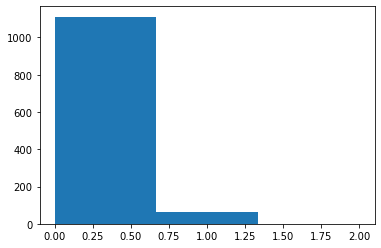

In [150]:
plt.hist(binclass_isaura[binclass_isaura.eblob2 > blob2_cut].trackID, bins = 3)

Here we histogram all the tracks energiesfrom all the events

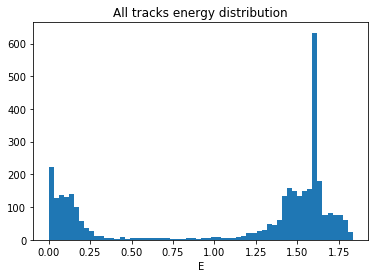

In [131]:
plt.hist(binclass_isaura.energy, bins = 60)
plt.title('All tracks energy distribution')
plt.xlabel('E')
plt.show()

And now, the energies of the tracks from events that have just one track

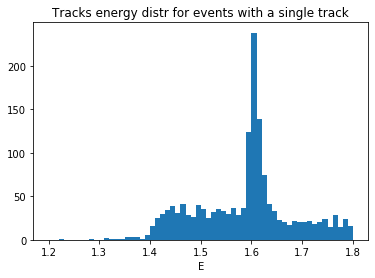

In [128]:
plt.hist(single_track_events.energy, bins = 60, range=[1.2, 1.8])
plt.title('Tracks energy distr for events with a single track')
plt.xlabel('E')
plt.show()

And very similar, the most energetic tracks from each event energy distribution. We can see a bigger tail in the left because of the events that their most energetic track is not that energetic i guess

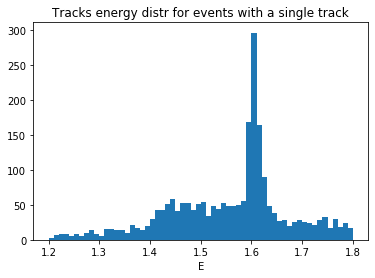

In [129]:
plt.hist(most_energetic_tracks.energy, bins = 60, range=[1.2, 1.8])
plt.title('Most energetic tracks energy distr')
plt.xlabel('E')
plt.show()

Supongo q la población en trazas pequeñas son trazas que salen de la reconstrucción de beersheba... es decir no son muy útiles, pero el corte que estoy haciendo es en EVENTOS q tengan solo una traza, no es q haya un evento y coja solo la primera traza..... en fin (voy a probar esta segunda opcion, es simplemente tomar los que tengan traza id = 0)

Quizás tiene más sentido coger las de traza id = 0 PORQUE así siempre coges las de single track y además tb coges muchos casos en los que quizás hay alguna traza espuria de la reconstrucción q se etiqueta como fantasma y punto...

Además, para comparar con mi labelling supongo que haré eso tb.. aunqeu fijo que si hago el corte en energías de blob 2 las trazas que no son la traza 0 dan como q tienen unsolo blob... al menos en su mayoria

In [134]:
most_energetic_tracks[most_energetic_tracks.eblob2 > blob2_cut]

,dataset_id,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,...,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z,binclass
0,0,100000050,0,1.431453,83.407169,23,3437,2,-22.5,50.5,...,24.650485,66.307430,348.010709,0.796947,0.411878,0.000000,15.0,15.0,15.0,0
2,1,100000051,0,1.632143,62.193966,24,3368,1,-37.5,33.5,...,0.483401,81.464169,94.413664,0.467121,0.351439,0.000000,15.0,15.0,15.0,0
6,4,100000054,0,1.608891,98.407169,19,3600,1,84.5,109.5,...,102.266452,139.487426,347.878971,0.593266,0.537392,0.000000,15.0,15.0,15.0,1
7,5,100000055,0,1.614513,62.193966,23,3334,1,3.5,107.5,...,45.337130,150.040916,168.595554,0.539249,0.445584,0.000000,15.0,15.0,15.0,1
8,6,100000056,0,1.605118,66.961524,15,3454,1,64.5,-2.5,...,75.856432,32.101323,185.651159,0.833312,0.535519,0.000000,15.0,15.0,15.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3463,2405,100000581,0,1.603960,88.174728,22,3423,1,-40.5,9.5,...,-32.529716,17.725911,317.262515,0.634739,0.620029,0.000000,15.0,15.0,15.0,1
3466,2407,100000583,0,1.443112,73.174728,25,2677,1,-64.5,103.5,...,-22.836380,152.020719,130.724850,0.747412,0.397221,0.000000,15.0,15.0,15.0,1
3475,2414,100000590,0,1.604459,130.601135,26,4018,1,-85.5,89.5,...,-20.990504,154.308815,373.770392,0.567754,0.274593,0.000000,15.0,15.0,15.0,1
3476,2415,100000591,0,1.605224,47.193966,14,3196,1,89.5,34.5,...,108.273210,61.505816,301.713504,1.015166,0.608395,0.071846,15.0,15.0,15.0,0


In [137]:
single_track_events[(single_track_events.eblob2 > blob2_cut)]

,dataset_id,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,...,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z,binclass
2,1,100000051,0,1.632143,62.193966,24,3368,1,-37.5,33.5,...,0.483401,81.464169,94.413664,0.467121,0.351439,0.000000,15.0,15.0,15.0,0
6,4,100000054,0,1.608891,98.407169,19,3600,1,84.5,109.5,...,102.266452,139.487426,347.878971,0.593266,0.537392,0.000000,15.0,15.0,15.0,1
7,5,100000055,0,1.614513,62.193966,23,3334,1,3.5,107.5,...,45.337130,150.040916,168.595554,0.539249,0.445584,0.000000,15.0,15.0,15.0,1
8,6,100000056,0,1.605118,66.961524,15,3454,1,64.5,-2.5,...,75.856432,32.101323,185.651159,0.833312,0.535519,0.000000,15.0,15.0,15.0,1
9,7,100000057,0,1.599784,96.961524,25,3845,1,-48.5,-8.5,...,-19.758345,66.741437,465.796839,0.595896,0.448568,0.000000,15.0,15.0,15.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3461,2403,100000579,0,1.794695,113.407169,24,3813,1,-104.5,45.5,...,-29.364047,64.012556,279.178743,0.320135,0.281855,0.000000,15.0,15.0,15.0,0
3463,2405,100000581,0,1.603960,88.174728,22,3423,1,-40.5,9.5,...,-32.529716,17.725911,317.262515,0.634739,0.620029,0.000000,15.0,15.0,15.0,1
3466,2407,100000583,0,1.443112,73.174728,25,2677,1,-64.5,103.5,...,-22.836380,152.020719,130.724850,0.747412,0.397221,0.000000,15.0,15.0,15.0,1
3475,2414,100000590,0,1.604459,130.601135,26,4018,1,-85.5,89.5,...,-20.990504,154.308815,373.770392,0.567754,0.274593,0.000000,15.0,15.0,15.0,1


In [130]:
def hit_data_cuts_event(hits, bins, Rmax = np.nan, coords = ['x', 'y', 'z'], identifyer = 'dataset_id'):
    '''
    This function performs the fiducial and boundary cuts to the input hits.
    Args:
        hits: DATAFRAME
    Contains the hits information.
        bins: LIST OF ARRAYS
    Contains the desired bins in each coordinate.
        Rmax: NaN OR FLOAT
    Value to perform the fiducial cut of the hits. If NaN, the cut is not done.
        coords: LIST
    Title of the columns for the coordinates.
    RETURNS:
        hits_cut: DATAFRAME
    The same dataframe with the cut performed on the hits.
    
        hits_del: DATAFRAME
    Hits that were substracted from the initial hits because of the cut.
    
        hits_del_event: DATAFRAME
    The dataframe with only the events that pass the cut.
    '''

    #Creo el boundary cut (elimina hits fuera del tamaño del detector deseado)
    binsX, binsY, binsZ = bins
    boundary_cut = (hits[coords[0]]>=binsX.min()) & (hits[coords[0]]<=binsX.max())\
                 & (hits[coords[1]]>=binsY.min()) & (hits[coords[1]]<=binsY.max())\
                 & (hits[coords[2]]>=binsZ.min()) & (hits[coords[2]]<=binsZ.max())

    #Creo el fiducial cut (toma los hits dentro de cierto radio)
    if np.isnan(Rmax):
        fiducial_cut = pd.Series(np.ones(len(hits), dtype=bool)) #creates a mask with all trues
    else:
        fiducial_cut = (hits[coords[0]]**2+hits[coords[1]]**2)<Rmax**2
    
    
    #Finalmente escojo dichos hits
    hits_cut = hits[boundary_cut & fiducial_cut].reset_index(drop = True)
    
    #Y los hits eliminados
    hits_del = hits[~(boundary_cut & fiducial_cut)]
    
    #Y hago el df eliminando todos los hits de eventos que tengan algún hit fuera
    del_events = hits_del[identifyer].unique()
    hits_del_event = hits.copy()
    for i in del_events:
        hits_del_event = hits_del_event[~(hits_del_event.dataset_id == i)]
    assert len(del_events) + len(hits_del_event[identifyer].unique()) == len(hits[identifyer].unique())
    return hits_cut, hits_del, hits_del_event